## feature engineering

In [193]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [194]:
# 추가한 새로운 feature
def cal_sm_1(new_dt):
  PA = new_dt['PA'] #타석
  AB = new_dt['AB'] #타수
  RBI = new_dt['RBI'] #타점
  RUN = new_dt['RUN'] #득점
  HIT = new_dt['HIT'] #총안타
  H2 = new_dt['H2'] #2루타
  H3 = new_dt['H3'] #3루타
  HR = new_dt['HR'] #홈런
  SB = new_dt['SB'] #도루
  CS = new_dt['CS'] #도루실패
  SH = new_dt['SH'] #희생타
  SF = new_dt['SF'] #희생플라이
  IB = new_dt['IB'] #고의4구
  HP = new_dt['HP'] #빈볼
  BB = new_dt['BB'] #총사구
  KK = new_dt['KK'] #삼진
  GD = new_dt['GD'] #병살타
  ERR = new_dt['ERR'] #실책

  # 타율 계산
  new_dt['AVG'] = HIT/AB

  # 순수 1루타 계산
  new_dt['H1'] = HIT - H2 - H3 - HR
  H1 = new_dt['H1']

  # OBP(출루율)
  new_dt['OBP'] = (HIT+BB+HP)/(AB+BB+SF+HP)
  # SLG(장타율)
  new_dt['SLG'] = (H1+2*H2+3*H3+4*HR)/AB

  # OPS = OBP+SLG
  OBP = new_dt['OBP']
  SLG = new_dt['SLG']
  new_dt['OPS'] = OBP + SLG

  # GPA = (1.8*OBP+SLG)/4 OPS의 단점을 보완
  new_dt['GPA'] = (1.8*new_dt['OBP'] + new_dt['SLG'])/4

  # IsoP = SLG - AVG 순수장타율
  AVG = new_dt['AVG']
  new_dt['IsoP'] = SLG - AVG

  # RC(Run Created)
  new_dt['RC'] = ((HIT+BB-CS+HP-GD) * ((H1+2*H2+3*H3+4*HR)+0.26*(BB-IB+HP)) + (0.52*SH+SF+SB)) / (AB+BB+HP+SH+SF)

  # XR (eXtrapolated Runs, 추정득점(타자의 득점공헌도))
  new_dt['XR'] = (H1*0.5 + H2*0.72 + H3*1.04 + HR*1.44 + (HP+BB-IB)*0.34 + IB*0.25 + SB*0.18 - CS*0.32
                  - (AB-HIT-KK)*0.09 - KK*0.098 - GD*0.37 + SF*0.37 + SH*0.04 )

  # BABIP = (총 안타수-홈런)/(타수-삼진-홈런+희생플라이)
  new_dt['BABIP'] = (HIT-HR)/(AB-KK-HR+SF)

  # OBP = (HIT+BB+HP)/(AB+BB+SF+HP) 출루율
  new_dt['OBP'] = (HIT+BB+HP)/(AB+BB+SF+HP)

  # SLG = (HIT+2*H2+3*H3+4*HR)/AB 장타율
  new_dt['SLG'] = (H1+2*H2+3*H3+4*HR)/AB

  # OPS+ = 100*((OBP/lgOBP+SLG/lgSLG)-1)[/BPF]
  # lgOBP: 리그 평균 출루율 / lgSLG: 리그 평균 장타율
  lgOBP = new_dt['OBP'].mean() # 결측값(NaN) 제외하고 리그 평균 계산
  lgSLG = new_dt['SLG'].mean()
  new_dt['OPS_plus'] = 100*((new_dt['OBP']/lgOBP+new_dt['SLG']/lgSLG)-1)

  # 타수가 극단적으로 적은 타자들로 인해 기록이 부정확할 확률이 높음
  # OPS+ 계산에는 원래 파크팩터를 사용하기도 함. 그러나 시즌 총 기록에서 경기별 패크팩터를 어떻게 대입할지는 모르겠음.

  return new_dt

In [195]:
# 2016 데이터로 확인 
df = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2016.csv')
df.tail()

,G_ID,GDAY_DS,T_ID,VS_T_ID,HEADER_NO,TB_SC,PA,AB,RBI,RUN,...,BB,IB,HP,KK,GD,ERR,LOB,P_HRA_RT,P_AB_CN,P_HIT_CN
1435,20161008SSSK0,20161008,SS,SK,0,T,39,36,5,6,...,3,0,0,4,1,2,6,0.250000,8,2
1436,20161009KTNC0,20161009,NC,KT,0,B,41,39,3,4,...,1,0,1,13,0,0,10,0.111111,18,2
1437,20161009KTNC0,20161009,KT,NC,0,T,43,38,5,7,...,3,0,0,7,0,0,9,0.100000,10,1
1438,20161009WOLT0,20161009,LT,WO,0,B,38,36,8,8,...,1,0,1,4,2,0,6,0.416667,12,5
1439,20161009WOLT0,20161009,WO,LT,0,T,38,33,5,5,...,3,0,0,6,1,3,6,0.428571,7,3


In [196]:
# 쓰이지 않는 피처 제거
df.drop(['G_ID'], axis=1, inplace=True)
df.drop(['GDAY_DS'], axis=1, inplace=True)
df.drop(['HEADER_NO'], axis=1, inplace=True)
df.drop(['TB_SC'], axis=1, inplace=True)

In [197]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

team_label = encoder.fit_transform(df['T_ID'])
vs_team_label = encoder.fit_transform(df['VS_T_ID'])

print(team_label)
print(vs_team_label)

[3 0 5 ... 2 4 9]
[0 3 1 ... 5 9 4]


In [198]:
df['T_ID'] = team_label
df['VS_T_ID'] = vs_team_label

df.tail()

,T_ID,VS_T_ID,PA,AB,RBI,RUN,HIT,H2,H3,HR,...,BB,IB,HP,KK,GD,ERR,LOB,P_HRA_RT,P_AB_CN,P_HIT_CN
1435,8,7,39,36,5,6,10,2,0,2,...,3,0,0,4,1,2,6,0.250000,8,2
1436,5,2,41,39,3,4,12,4,0,0,...,1,0,1,13,0,0,10,0.111111,18,2
1437,2,5,43,38,5,7,14,3,0,0,...,3,0,0,7,0,0,9,0.100000,10,1
1438,4,9,38,36,8,8,11,2,0,2,...,1,0,1,4,2,0,6,0.416667,12,5
1439,9,4,38,33,5,5,10,0,0,0,...,3,0,0,6,1,3,6,0.428571,7,3


In [199]:
df.info() # null, object check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   T_ID      1440 non-null   int32  
 1   VS_T_ID   1440 non-null   int32  
 2   PA        1440 non-null   int64  
 3   AB        1440 non-null   int64  
 4   RBI       1440 non-null   int64  
 5   RUN       1440 non-null   int64  
 6   HIT       1440 non-null   int64  
 7   H2        1440 non-null   int64  
 8   H3        1440 non-null   int64  
 9   HR        1440 non-null   int64  
 10  SB        1440 non-null   int64  
 11  CS        1440 non-null   int64  
 12  SH        1440 non-null   int64  
 13  SF        1440 non-null   int64  
 14  BB        1440 non-null   int64  
 15  IB        1440 non-null   int64  
 16  HP        1440 non-null   int64  
 17  KK        1440 non-null   int64  
 18  GD        1440 non-null   int64  
 19  ERR       1440 non-null   int64  
 20  LOB       1440 non-null   int6

In [200]:
#  팀 Set 제작
team = set()
for i in df['T_ID']:
  team.add(i)
print("2016년 참여 팀 수 :", len(team))

2016년 참여 팀 수 : 10


In [201]:
df = cal_sm_1(df)
df.head()

,T_ID,VS_T_ID,PA,AB,RBI,RUN,HIT,H2,H3,HR,...,H1,OBP,SLG,OPS,GPA,IsoP,RC,XR,BABIP,OPS_plus
0,3,0,47,42,4,5,9,2,0,1,...,6,0.282609,0.333333,0.615942,0.210507,0.119048,3.893617,4.262,0.266667,57.164141
1,0,3,52,46,4,4,13,2,0,0,...,11,0.326531,0.326087,0.652618,0.228461,0.043478,4.581923,4.660,0.361111,67.786035
2,5,1,36,30,5,5,9,2,0,2,...,5,0.400000,0.566667,0.966667,0.321667,0.266667,6.622778,6.228,0.368421,144.624940
3,1,5,38,34,3,4,8,3,0,1,...,4,0.315789,0.411765,0.727554,0.245046,0.176471,4.353684,4.170,0.304348,84.802227
4,7,2,36,36,4,4,10,5,0,1,...,4,0.277778,0.500000,0.777778,0.250000,0.222222,4.500000,4.274,0.321429,94.769544


In [202]:
cl = df.columns.tolist()
arr = []
df18 = pd.DataFrame(index=range(0,0), columns=cl) 
print(df18)
for i in team :
  # 선수 별로 새로운 Dataframe 생성
  hitter_df = df[df['T_ID'] == i ]
  hitter_df.reset_index(drop=True, inplace=True)
    
  # 경기 데이터가 18개 이상이라면
  count = len(hitter_df)//18
    
  if count != 0 :
    #print(count)
    for k in range(count):
      s = k * 18
      #print(s,'부터',s+17,'까지의 합')

      total = hitter_df.loc[s] + hitter_df.loc[s+1] + hitter_df.loc[s+2] + hitter_df.loc[s+3] + hitter_df.loc[s+4] + hitter_df.loc[s+5]+ hitter_df.loc[s+6] + hitter_df.loc[s+7] + hitter_df.loc[s+8] + hitter_df.loc[s+9] + hitter_df.loc[s+10] + hitter_df.loc[s+11]+ hitter_df.loc[s+12] + hitter_df.loc[s+13] + hitter_df.loc[s+14] + hitter_df.loc[s+15] + hitter_df.loc[s+16] + hitter_df.loc[s+17]
      total = total / 18

      df18 = df18.append(pd.Series(total, index=df18.columns), ignore_index=True)
      #print(k, end=' ')
      if k == 0 :
        pass
      else :
        arr.append(total['AVG'])
    arr.append(0)

Empty DataFrame
Columns: [T_ID, VS_T_ID, PA, AB, RBI, RUN, HIT, H2, H3, HR, SB, CS, SH, SF, BB, IB, HP, KK, GD, ERR, LOB, P_HRA_RT, P_AB_CN, P_HIT_CN, AVG, H1, OBP, SLG, OPS, GPA, IsoP, RC, XR, BABIP, OPS_plus]
Index: []

[0 rows x 35 columns]


In [203]:
df18['label']=arr
df18 = df18[df18['label']!=0]
df18_2 = df18.copy()

df18_2 = df18_2.fillna(0)
df18_2.reset_index(drop=True, inplace=True)

In [204]:
df18_2

,T_ID,VS_T_ID,PA,AB,RBI,RUN,HIT,H2,H3,HR,...,OBP,SLG,OPS,GPA,IsoP,RC,XR,BABIP,OPS_plus,label
0,0.0,5.333333,39.888889,35.111111,3.500000,3.722222,9.388889,1.666667,0.111111,0.500000,...,0.332277,0.357191,0.689468,0.238822,0.093652,4.285463,4.129667,0.330310,76.668216,0.251589
1,0.0,4.444444,38.944444,33.611111,4.222222,4.500000,8.722222,1.500000,0.055556,0.888889,...,0.338219,0.378336,0.716555,0.246783,0.126747,4.722567,4.648556,0.292843,83.277284,0.298701
2,0.0,5.944444,41.722222,36.555556,6.444444,6.611111,10.944444,2.000000,0.166667,1.166667,...,0.371567,0.458981,0.830548,0.281950,0.160280,6.424161,6.095667,0.333523,111.479614,0.288870
3,0.0,5.055556,39.833333,35.611111,5.055556,5.055556,10.333333,1.388889,0.277778,1.388889,...,0.346885,0.460150,0.807035,0.271136,0.171280,5.776253,5.543222,0.331675,104.832128,0.303723
4,0.0,5.111111,41.555556,35.722222,7.166667,7.333333,11.055556,1.833333,0.277778,1.222222,...,0.383890,0.470915,0.854805,0.290479,0.167192,6.884832,6.519333,0.331479,117.724848,0.296674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,9.0,3.388889,37.833333,33.555556,4.277778,4.555556,9.388889,1.388889,0.333333,0.888889,...,0.337612,0.408155,0.745766,0.253964,0.135607,4.962820,4.763778,0.311914,90.077299,0.289702
66,9.0,3.388889,40.444444,35.166667,5.777778,6.222222,10.333333,2.055556,0.222222,0.722222,...,0.369351,0.423925,0.793276,0.272189,0.134223,5.700223,5.620889,0.339186,102.663607,0.331549
67,9.0,3.277778,41.666667,35.500000,7.055556,7.722222,11.833333,2.388889,0.333333,1.277778,...,0.411428,0.521701,0.933129,0.315568,0.190152,7.616918,7.334889,0.358204,137.318143,0.293909
68,9.0,4.888889,39.500000,34.666667,4.833333,5.111111,10.388889,1.611111,0.166667,1.055556,...,0.364748,0.438844,0.803591,0.273847,0.144935,5.742252,5.668111,0.326475,104.860238,0.282834


In [205]:
df18_3 = df18_2[['AB', 'HIT', 'KK', 'AVG', 'OPS', 'RC', 'BABIP', 'OPS_plus', 'label']]
df18_3

,AB,HIT,KK,AVG,OPS,RC,BABIP,OPS_plus,label
0,35.111111,9.388889,8.166667,0.263539,0.689468,4.285463,0.330310,76.668216,0.251589
1,33.611111,8.722222,7.333333,0.251589,0.716555,4.722567,0.292843,83.277284,0.298701
2,36.555556,10.944444,6.444444,0.298701,0.830548,6.424161,0.333523,111.479614,0.288870
3,35.611111,10.333333,7.722222,0.288870,0.807035,5.776253,0.331675,104.832128,0.303723
4,35.722222,11.055556,5.777778,0.303723,0.854805,6.884832,0.331479,117.724848,0.296674
...,...,...,...,...,...,...,...,...,...
65,33.555556,9.388889,6.333333,0.272548,0.745766,4.962820,0.311914,90.077299,0.289702
66,35.166667,10.333333,6.833333,0.289702,0.793276,5.700223,0.339186,102.663607,0.331549
67,35.500000,11.833333,5.222222,0.331549,0.933129,7.616918,0.358204,137.318143,0.293909
68,34.666667,10.388889,5.722222,0.293909,0.803591,5.742252,0.326475,104.860238,0.282834


## multi regressor
- xgb
- lgb
- random forest

Random Forest

In [18]:
!pip install xgboost

In [20]:
!pip install lightgbm

In [21]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = df18_3['label']
X_data = df18_3.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=123)

In [22]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.018346885691373473


In [23]:
print(np.mean(abs(y_pred - y_test)))

0.013756953542321614


XGBoost

In [24]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.019084044851237995


In [25]:
print(np.mean(abs(y_pred - y_test)))

0.015364197351590973


LGBoost

In [26]:
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.01593087880446067


In [27]:
print(np.mean(abs(y_pred - y_test)))

0.011911385285019066


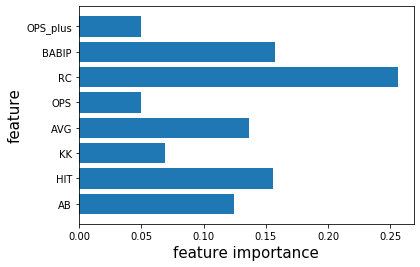

In [28]:
# feature importance
import matplotlib.pyplot as plt
%matplotlib inline

n_feature = X_data.shape[1]

index = np.arange(n_feature)

plt.barh(index, xgb.feature_importances_)

plt.yticks(index, X_data.columns)


plt.xlabel('feature importance', size=15)

plt.ylabel('feature', size=15)

plt.show()



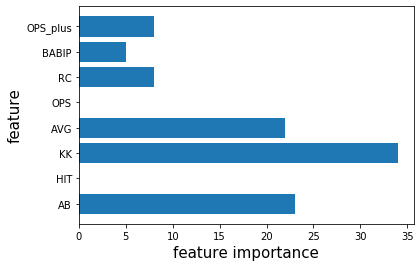

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

n_feature = X_data.shape[1]

index = np.arange(n_feature)

plt.barh(index, lgb.feature_importances_)

plt.yticks(index, X_data.columns)


plt.xlabel('feature importance', size=15)

plt.ylabel('feature', size=15)

plt.show()



In [30]:
# 각 데이터 묶어서 확인 
def years_preprocessing(df):

  # 쓰이지 않는 피처 제거
  df.drop(['G_ID'], axis=1, inplace=True)
  df.drop(['GDAY_DS'], axis=1, inplace=True)
  df.drop(['HEADER_NO'], axis=1, inplace=True)
  df.drop(['TB_SC'], axis=1, inplace=True)

  encoder = LabelEncoder()

  team_label = encoder.fit_transform(df['T_ID'])
  vs_team_label = encoder.fit_transform(df['VS_T_ID'])

  df['T_ID'] = team_label
  df['VS_T_ID'] = vs_team_label

  team = set()
  for i in df['T_ID']:
    team.add(i)

  df = cal_sm_1(df)

  cl = df.columns.tolist()
  arr = []
  df18 = pd.DataFrame(index=range(0,0), columns=cl) 
  print(df18)
  for i in team :
    # 선수 별로 새로운 Dataframe 생성
    hitter_df = df[df['T_ID'] == i ]
    hitter_df.reset_index(drop=True, inplace=True)
      
    # 경기 데이터가 18개 이상이라면
    count = len(hitter_df)//18
      
    if count != 0 :
      #print(count)
      for k in range(count):
        s = k * 18
        #print(s,'부터',s+17,'까지의 합')

        total = hitter_df.loc[s] + hitter_df.loc[s+1] + hitter_df.loc[s+2] + hitter_df.loc[s+3] + hitter_df.loc[s+4] + hitter_df.loc[s+5]+ hitter_df.loc[s+6] + hitter_df.loc[s+7] + hitter_df.loc[s+8] + hitter_df.loc[s+9] + hitter_df.loc[s+10] + hitter_df.loc[s+11]+ hitter_df.loc[s+12] + hitter_df.loc[s+13] + hitter_df.loc[s+14] + hitter_df.loc[s+15] + hitter_df.loc[s+16] + hitter_df.loc[s+17]
        total = total / 18

        df18 = df18.append(pd.Series(total, index=df18.columns), ignore_index=True)
        #print(k, end=' ')
        if k == 0 :
          pass
        else :
          arr.append(total['AVG'])
      arr.append(0)

  df18['label']=arr
  df18 = df18[df18['label']!=0]
  df18_2 = df18.copy()

  df18_2 = df18_2.fillna(0)
  df18_2.reset_index(drop=True, inplace=True)

  return df18_2

In [31]:
# 전체 데이터 
df_16 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2016.csv')
df_17 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2017.csv')
df_18 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2018.csv')
df_19 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2019.csv')
df_20 = pd.read_csv('2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2020.csv')

In [32]:
df_16 = years_preprocessing(df_16)
print('16년 DONE')
df_17 = years_preprocessing(df_17)
print('17년 DONE')
df_18 = years_preprocessing(df_18)
print('18년 DONE')
df_19 = years_preprocessing(df_19)
print('19년 DONE')
df_20 = years_preprocessing(df_20)
print('20년 DONE')

Empty DataFrame
Columns: [T_ID, VS_T_ID, PA, AB, RBI, RUN, HIT, H2, H3, HR, SB, CS, SH, SF, BB, IB, HP, KK, GD, ERR, LOB, P_HRA_RT, P_AB_CN, P_HIT_CN, AVG, H1, OBP, SLG, OPS, GPA, IsoP, RC, XR, BABIP, OPS_plus]
Index: []

[0 rows x 35 columns]
16년 DONE
Empty DataFrame
Columns: [T_ID, VS_T_ID, PA, AB, RBI, RUN, HIT, H2, H3, HR, SB, CS, SH, SF, BB, IB, HP, KK, GD, ERR, LOB, P_HRA_RT, P_AB_CN, P_HIT_CN, AVG, H1, OBP, SLG, OPS, GPA, IsoP, RC, XR, BABIP, OPS_plus]
Index: []

[0 rows x 35 columns]
17년 DONE
Empty DataFrame
Columns: [T_ID, VS_T_ID, PA, AB, RBI, RUN, HIT, H2, H3, HR, SB, CS, SH, SF, BB, IB, HP, KK, GD, ERR, LOB, P_HRA_RT, P_AB_CN, P_HIT_CN, AVG, H1, OBP, SLG, OPS, GPA, IsoP, RC, XR, BABIP, OPS_plus]
Index: []

[0 rows x 35 columns]
18년 DONE
Empty DataFrame
Columns: [T_ID, VS_T_ID, PA, AB, RBI, RUN, HIT, H2, H3, HR, SB, CS, SH, SF, BB, IB, HP, KK, GD, ERR, LOB, P_HRA_RT, P_AB_CN, P_HIT_CN, AVG, H1, OBP, SLG, OPS, GPA, IsoP, RC, XR, BABIP, OPS_plus]
Index: []

[0 rows x 35 column

In [33]:
df_16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 36 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   T_ID      70 non-null     float64
 1   VS_T_ID   70 non-null     float64
 2   PA        70 non-null     float64
 3   AB        70 non-null     float64
 4   RBI       70 non-null     float64
 5   RUN       70 non-null     float64
 6   HIT       70 non-null     float64
 7   H2        70 non-null     float64
 8   H3        70 non-null     float64
 9   HR        70 non-null     float64
 10  SB        70 non-null     float64
 11  CS        70 non-null     float64
 12  SH        70 non-null     float64
 13  SF        70 non-null     float64
 14  BB        70 non-null     float64
 15  IB        70 non-null     float64
 16  HP        70 non-null     float64
 17  KK        70 non-null     float64
 18  GD        70 non-null     float64
 19  ERR       70 non-null     float64
 20  LOB       70 non-null     float64


In [34]:
df_all = pd.concat([df_16, df_17, df_18, df_19, df_20])
len(df_all) == len(df_16)+len(df_17)+len(df_18)+len(df_19)+len(df_20)

True

In [35]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 19
Data columns (total 36 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   T_ID      300 non-null    float64
 1   VS_T_ID   300 non-null    float64
 2   PA        300 non-null    float64
 3   AB        300 non-null    float64
 4   RBI       300 non-null    float64
 5   RUN       300 non-null    float64
 6   HIT       300 non-null    float64
 7   H2        300 non-null    float64
 8   H3        300 non-null    float64
 9   HR        300 non-null    float64
 10  SB        300 non-null    float64
 11  CS        300 non-null    float64
 12  SH        300 non-null    float64
 13  SF        300 non-null    float64
 14  BB        300 non-null    float64
 15  IB        300 non-null    float64
 16  HP        300 non-null    float64
 17  KK        300 non-null    float64
 18  GD        300 non-null    float64
 19  ERR       300 non-null    float64
 20  LOB       300 non-null    float64

In [36]:
df_all_3 = df_all.drop(['T_ID', 'VS_T_ID', 'PA', 'HIT', 'H2', 'H3', 'HR', 'SB', 'CS', 'SH', 'SF', 'HP', 'ERR', 'LOB', 'P_AB_CN', 
                        'P_HIT_CN', 'H1'], axis=1)

In [37]:
df_20

,T_ID,VS_T_ID,PA,AB,RBI,RUN,HIT,H2,H3,HR,...,OBP,SLG,OPS,GPA,IsoP,RC,XR,BABIP,OPS_plus,label
0,0.0,4.666667,37.000000,33.500000,3.666667,3.833333,8.555556,1.555556,0.055556,0.611111,...,0.314183,0.357369,0.671551,0.230724,0.104283,3.703305,3.691444,0.309945,81.318856,0.206963
1,0.0,5.666667,35.444444,32.111111,2.500000,2.666667,6.833333,0.888889,0.000000,0.666667,...,0.275056,0.295040,0.570096,0.197535,0.088077,2.803282,2.612667,0.245579,54.338950,0.258109
2,1.0,5.666667,39.888889,34.944444,4.611111,4.888889,9.611111,2.000000,0.000000,0.888889,...,0.347362,0.399747,0.747109,0.256250,0.131510,5.430966,5.027000,0.313268,101.612128,0.268770
3,1.0,4.000000,37.555556,33.277778,4.888889,4.944444,9.055556,1.333333,0.111111,1.222222,...,0.335364,0.423533,0.758897,0.256797,0.154762,5.035695,4.951444,0.292475,103.927630,0.265229
4,2.0,4.055556,41.111111,36.666667,6.222222,6.666667,11.388889,2.111111,0.444444,1.055556,...,0.354219,0.461820,0.816040,0.274854,0.160715,6.880524,6.299889,0.339175,118.966040,0.268235
5,2.0,5.166667,37.944444,34.388889,4.555556,4.833333,9.444444,1.666667,0.111111,1.222222,...,0.322369,0.423895,0.746263,0.251040,0.155660,5.299712,4.935778,0.308931,100.165752,0.295404
6,3.0,5.888889,38.000000,33.222222,5.277778,5.500000,9.111111,1.833333,0.166667,1.000000,...,0.349699,0.422355,0.772055,0.262954,0.151779,5.232770,5.044333,0.313755,107.885258,0.293580
7,3.0,4.833333,39.611111,35.444444,6.055556,6.277778,10.833333,1.944444,0.222222,1.111111,...,0.345347,0.446838,0.792185,0.267116,0.153258,6.163538,5.871444,0.318961,112.638717,0.268704
8,4.0,4.222222,38.722222,34.444444,4.388889,4.722222,9.166667,2.166667,0.000000,0.833333,...,0.326779,0.390217,0.716996,0.244605,0.129685,4.856400,4.759556,0.295042,93.159879,0.260839
9,4.0,3.388889,39.333333,34.722222,4.222222,4.611111,9.222222,1.444444,0.111111,0.611111,...,0.337673,0.360524,0.698197,0.242084,0.099685,4.570606,4.455333,0.302575,89.059077,0.277839


In [94]:
df_all_3.shape

(300, 19)

In [96]:
df_all_3_train = df_all_3[:200]
df_all_3_test = df_all_3[200:]

In [109]:
df_all_3_train.to_csv('train.csv', index = False)
df_all_3_test.to_csv('test.csv', index = False)

In [110]:
df_all_3.to_csv('df_train.csv', index = False)

## DNN

In [206]:
import pandas as pd
%tensorflow_version 1.x
import tensorflow
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras

UsageError: Line magic function `%tensorflow_version` not found.


In [207]:
y_target = df_all_3['label']
X_data = df_all_3.drop('label', axis=1)

In [208]:
X_train = X_data.values  
y_train = y_target.values

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [210]:
X_train.shape

(270, 19)

In [211]:
y_train # type array

array([0.26797708, 0.27057178, 0.28908456, 0.27110031, 0.31269879,
       0.29226233, 0.28129224, 0.27748556, 0.36087852, 0.26140948,
       0.27544485, 0.27464195, 0.26404793, 0.29667379, 0.28606919,
       0.25762743, 0.26775234, 0.30378999, 0.24492489, 0.33722679,
       0.25158912, 0.2682349 , 0.29540437, 0.2575842 , 0.26083888,
       0.24719123, 0.29007809, 0.29509608, 0.26267644, 0.28248284,
       0.24677426, 0.28173107, 0.2682895 , 0.30358877, 0.29079804,
       0.2862455 , 0.30032464, 0.31360157, 0.28933093, 0.22147495,
       0.26877048, 0.26407014, 0.32323398, 0.29222161, 0.30089594,
       0.31198082, 0.2665034 , 0.28777561, 0.2746631 , 0.27488554,
       0.30172442, 0.29390864, 0.26043902, 0.31145453, 0.30928744,
       0.25876286, 0.31379399, 0.21720174, 0.30746617, 0.24962969,
       0.26627833, 0.28064107, 0.27438031, 0.2971281 , 0.25736758,
       0.29084587, 0.29304651, 0.20696302, 0.25853733, 0.26056189,
       0.25178748, 0.2874318 , 0.31923622, 0.26522881, 0.27953

In [212]:
X_train

array([[ 35.61111111,   5.        ,   5.22222222, ...,   0.3424025 ,
        101.53704657,   1.        ],
       [ 32.77777778,   2.55555556,   2.83333333, ...,   0.27107272,
         78.66791327,  -1.        ],
       [ 34.66666667,   3.94444444,   4.22222222, ...,   0.32534278,
         97.37878734,   1.        ],
       ...,
       [ 35.38888889,   4.33333333,   4.77777778, ...,   0.33945069,
         99.11353702,   1.        ],
       [ 33.61111111,   4.27777778,   4.61111111, ...,   0.3089595 ,
         97.69691306,   1.        ],
       [ 35.16666667,   7.38888889,   7.77777778, ...,   0.32728909,
        129.68651015,   1.        ]])

In [213]:
#!pip install keras

In [214]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [215]:
import keras

In [216]:
keras.initializers.he_normal(seed=None) #randomnormal

In [217]:
#초기화 
clf = Sequential([
    Dense(16, kernel_initializer='normal', activation='relu'),
    Dropout(0.50),
    Dense(32, kernel_initializer='normal', activation='relu'),
    Dropout(0.50),
    Dense(1, kernel_initializer='normal', activation='relu'),
])

In [218]:
#학습
clf.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [57]:
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)

clf.fit(X_train, y_train, batch_size=30, epochs=10000, callbacks=[early_stop])

Epoch 1/10000
9/9 [==============================] - 0s 3ms/step - loss: 0.0473 - mse: 0.0473
Epoch 2/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0318 - mse: 0.0318
Epoch 3/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0217 - mse: 0.0217
Epoch 4/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0154 - mse: 0.0154
Epoch 5/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0147 - mse: 0.0147
Epoch 6/10000
9/9 [==============================] - 0s 3ms/step - loss: 0.0133 - mse: 0.0133
Epoch 7/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0111 - mse: 0.0111
Epoch 8/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0107 - mse: 0.0107
Epoch 9/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0096 - mse: 0.0096
Epoch 10/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0080 - mse: 0.0080
Epoch 11/10000
9/9 [==============================] - 0s 2m

Epoch 29/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0023 - mse: 0.0023
Epoch 30/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0022 - mse: 0.0022
Epoch 31/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0022 - mse: 0.0022
Epoch 32/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018
Epoch 33/10000
9/9 [==============================] - 0s 3ms/step - loss: 0.0020 - mse: 0.0020
Epoch 34/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0020 - mse: 0.0020
Epoch 35/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016
Epoch 36/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0018 - mse: 0.0018
Epoch 37/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016    
Epoch 38/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0016 - mse: 0.0016
Epoch 39/10000
9/9 [==========================

9/9 [==============================] - 0s 3ms/step - loss: 9.8600e-04 - mse: 9.8600e-04
Epoch 57/10000
9/9 [==============================] - 0s 2ms/step - loss: 0.0010 - mse: 0.0010    
Epoch 58/10000
9/9 [==============================] - 0s 2ms/step - loss: 9.4003e-04 - mse: 9.4003e-04
Epoch 59/10000
9/9 [==============================] - 0s 3ms/step - loss: 0.0010 - mse: 0.0010    
Epoch 60/10000
9/9 [==============================] - 0s 2ms/step - loss: 8.5481e-04 - mse: 8.5481e-04
Epoch 61/10000
9/9 [==============================] - 0s 2ms/step - loss: 8.3842e-04 - mse: 8.3842e-04
Epoch 62/10000
9/9 [==============================] - 0s 4ms/step - loss: 9.1948e-04 - mse: 9.1948e-04
Epoch 63/10000
9/9 [==============================] - 0s 2ms/step - loss: 9.2831e-04 - mse: 9.2831e-04
Epoch 64/10000
9/9 [==============================] - 0s 2ms/step - loss: 9.5767e-04 - mse: 9.5767e-04
Epoch 65/10000
9/9 [==============================] - 0s 3ms/step - loss: 8.2185e-04 - mse: 8.21

9/9 [==============================] - 0s 2ms/step - loss: 6.6194e-04 - mse: 6.6194e-04
Epoch 84/10000
9/9 [==============================] - 0s 2ms/step - loss: 6.5274e-04 - mse: 6.5274e-04
Epoch 85/10000
9/9 [==============================] - 0s 2ms/step - loss: 6.3217e-04 - mse: 6.3217e-04
Epoch 86/10000
9/9 [==============================] - 0s 2ms/step - loss: 6.6290e-04 - mse: 6.6290e-04
Epoch 87/10000
9/9 [==============================] - 0s 2ms/step - loss: 6.6659e-04 - mse: 6.6659e-04
Epoch 88/10000
9/9 [==============================] - 0s 2ms/step - loss: 6.2579e-04 - mse: 6.2579e-04
Epoch 89/10000
9/9 [==============================] - 0s 2ms/step - loss: 6.5475e-04 - mse: 6.5475e-04
Epoch 90/10000
9/9 [==============================] - 0s 2ms/step - loss: 5.8509e-04 - mse: 5.8509e-04
Epoch 91/10000
9/9 [==============================] - 0s 2ms/step - loss: 6.5843e-04 - mse: 6.5843e-04
Epoch 92/10000
9/9 [==============================] - 0s 2ms/step - loss: 5.6492e-04 - m

9/9 [==============================] - 0s 2ms/step - loss: 5.1298e-04 - mse: 5.1298e-04
Epoch 137/10000
9/9 [==============================] - 0s 2ms/step - loss: 5.0731e-04 - mse: 5.0731e-04
Epoch 138/10000
9/9 [==============================] - 0s 2ms/step - loss: 5.0314e-04 - mse: 5.0314e-04
Epoch 139/10000
9/9 [==============================] - 0s 2ms/step - loss: 5.3516e-04 - mse: 5.3516e-04
Epoch 140/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.9849e-04 - mse: 4.9849e-04
Epoch 141/10000
9/9 [==============================] - 0s 2ms/step - loss: 5.1826e-04 - mse: 5.1826e-04
Epoch 142/10000
9/9 [==============================] - 0s 2ms/step - loss: 5.0866e-04 - mse: 5.0866e-04
Epoch 143/10000
9/9 [==============================] - 0s 3ms/step - loss: 5.2171e-04 - mse: 5.2171e-04
Epoch 144/10000
9/9 [==============================] - 0s 2ms/step - loss: 5.0967e-04 - mse: 5.0967e-04
Epoch 145/10000
9/9 [==============================] - 0s 2ms/step - loss: 5.062

9/9 [==============================] - 0s 2ms/step - loss: 4.7714e-04 - mse: 4.7714e-04
Epoch 190/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7680e-04 - mse: 4.7680e-04
Epoch 191/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.9452e-04 - mse: 4.9452e-04
Epoch 192/10000
9/9 [==============================] - 0s 3ms/step - loss: 5.0211e-04 - mse: 5.0211e-04
Epoch 193/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.9006e-04 - mse: 4.9006e-04
Epoch 194/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8339e-04 - mse: 4.8339e-04
Epoch 195/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.9201e-04 - mse: 4.9201e-04
Epoch 196/10000
9/9 [==============================] - 0s 3ms/step - loss: 5.0562e-04 - mse: 5.0562e-04
Epoch 197/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7097e-04 - mse: 4.7097e-04
Epoch 198/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.848

9/9 [==============================] - 0s 3ms/step - loss: 4.8646e-04 - mse: 4.8646e-04
Epoch 243/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8986e-04 - mse: 4.8986e-04
Epoch 244/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8259e-04 - mse: 4.8259e-04
Epoch 245/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7951e-04 - mse: 4.7951e-04
Epoch 246/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6663e-04 - mse: 4.6663e-04
Epoch 247/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8182e-04 - mse: 4.8182e-04
Epoch 248/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8226e-04 - mse: 4.8226e-04
Epoch 249/10000
9/9 [==============================] - 0s 3ms/step - loss: 5.0526e-04 - mse: 5.0526e-04
Epoch 250/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8279e-04 - mse: 4.8279e-04
Epoch 251/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.767

9/9 [==============================] - 0s 3ms/step - loss: 4.7830e-04 - mse: 4.7830e-04
Epoch 296/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7055e-04 - mse: 4.7055e-04
Epoch 297/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7534e-04 - mse: 4.7534e-04
Epoch 298/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8242e-04 - mse: 4.8242e-04
Epoch 299/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8547e-04 - mse: 4.8547e-04
Epoch 300/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7797e-04 - mse: 4.7797e-04
Epoch 301/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7637e-04 - mse: 4.7637e-04
Epoch 302/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6011e-04 - mse: 4.6011e-04
Epoch 303/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.6450e-04 - mse: 4.6450e-04
Epoch 304/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.833

9/9 [==============================] - 0s 2ms/step - loss: 4.7430e-04 - mse: 4.7430e-04
Epoch 349/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8265e-04 - mse: 4.8265e-04
Epoch 350/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7804e-04 - mse: 4.7804e-04
Epoch 351/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6085e-04 - mse: 4.6085e-04
Epoch 352/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6799e-04 - mse: 4.6799e-04
Epoch 353/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5961e-04 - mse: 4.5961e-04
Epoch 354/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6716e-04 - mse: 4.6716e-04
Epoch 355/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7107e-04 - mse: 4.7107e-04
Epoch 356/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7664e-04 - mse: 4.7664e-04
Epoch 357/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.566

9/9 [==============================] - 0s 2ms/step - loss: 4.6155e-04 - mse: 4.6155e-04
Epoch 402/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7045e-04 - mse: 4.7045e-04
Epoch 403/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8573e-04 - mse: 4.8573e-04
Epoch 404/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6821e-04 - mse: 4.6821e-04
Epoch 405/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6588e-04 - mse: 4.6588e-04
Epoch 406/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6829e-04 - mse: 4.6829e-04
Epoch 407/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7404e-04 - mse: 4.7404e-04
Epoch 408/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6560e-04 - mse: 4.6560e-04
Epoch 409/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7794e-04 - mse: 4.7794e-04
Epoch 410/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.653

9/9 [==============================] - 0s 2ms/step - loss: 4.6045e-04 - mse: 4.6045e-04
Epoch 455/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6212e-04 - mse: 4.6212e-04
Epoch 456/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5770e-04 - mse: 4.5770e-04
Epoch 457/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8542e-04 - mse: 4.8542e-04
Epoch 458/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6735e-04 - mse: 4.6735e-04
Epoch 459/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7121e-04 - mse: 4.7121e-04
Epoch 460/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8811e-04 - mse: 4.8811e-04
Epoch 461/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7239e-04 - mse: 4.7239e-04
Epoch 462/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7017e-04 - mse: 4.7017e-04
Epoch 463/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.640

9/9 [==============================] - 0s 2ms/step - loss: 4.5972e-04 - mse: 4.5972e-04
Epoch 508/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7775e-04 - mse: 4.7775e-04
Epoch 509/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7900e-04 - mse: 4.7900e-04
Epoch 510/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5115e-04 - mse: 4.5115e-04
Epoch 511/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8375e-04 - mse: 4.8375e-04
Epoch 512/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5437e-04 - mse: 4.5437e-04
Epoch 513/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5098e-04 - mse: 4.5098e-04
Epoch 514/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6738e-04 - mse: 4.6738e-04
Epoch 515/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6100e-04 - mse: 4.6100e-04
Epoch 516/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.514

9/9 [==============================] - 0s 2ms/step - loss: 4.5127e-04 - mse: 4.5127e-04
Epoch 561/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7070e-04 - mse: 4.7070e-04
Epoch 562/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6816e-04 - mse: 4.6816e-04
Epoch 563/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6968e-04 - mse: 4.6968e-04
Epoch 564/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4602e-04 - mse: 4.4602e-04
Epoch 565/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7245e-04 - mse: 4.7245e-04
Epoch 566/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7495e-04 - mse: 4.7495e-04
Epoch 567/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4608e-04 - mse: 4.4608e-04
Epoch 568/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7828e-04 - mse: 4.7828e-04
Epoch 569/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.699

9/9 [==============================] - 0s 2ms/step - loss: 4.7649e-04 - mse: 4.7649e-04
Epoch 614/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5393e-04 - mse: 4.5393e-04
Epoch 615/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7457e-04 - mse: 4.7457e-04
Epoch 616/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5618e-04 - mse: 4.5618e-04
Epoch 617/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8229e-04 - mse: 4.8229e-04
Epoch 618/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7490e-04 - mse: 4.7490e-04
Epoch 619/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6252e-04 - mse: 4.6252e-04
Epoch 620/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6702e-04 - mse: 4.6702e-04
Epoch 621/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3463e-04 - mse: 4.3463e-04
Epoch 622/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.757

9/9 [==============================] - 0s 2ms/step - loss: 4.6747e-04 - mse: 4.6747e-04
Epoch 667/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7489e-04 - mse: 4.7489e-04
Epoch 668/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7038e-04 - mse: 4.7038e-04
Epoch 669/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6834e-04 - mse: 4.6834e-04
Epoch 670/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6383e-04 - mse: 4.6383e-04
Epoch 671/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7504e-04 - mse: 4.7504e-04
Epoch 672/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5391e-04 - mse: 4.5391e-04
Epoch 673/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7417e-04 - mse: 4.7417e-04
Epoch 674/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4461e-04 - mse: 4.4461e-04
Epoch 675/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.705

9/9 [==============================] - 0s 2ms/step - loss: 4.6637e-04 - mse: 4.6637e-04
Epoch 720/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6939e-04 - mse: 4.6939e-04
Epoch 721/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7634e-04 - mse: 4.7634e-04
Epoch 722/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6594e-04 - mse: 4.6594e-04
Epoch 723/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6297e-04 - mse: 4.6297e-04
Epoch 724/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4451e-04 - mse: 4.4451e-04
Epoch 725/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6708e-04 - mse: 4.6708e-04
Epoch 726/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7324e-04 - mse: 4.7324e-04
Epoch 727/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8009e-04 - mse: 4.8009e-04
Epoch 728/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.562

9/9 [==============================] - 0s 2ms/step - loss: 4.5261e-04 - mse: 4.5261e-04
Epoch 773/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4278e-04 - mse: 4.4278e-04
Epoch 774/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5812e-04 - mse: 4.5812e-04
Epoch 775/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6871e-04 - mse: 4.6871e-04
Epoch 776/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6933e-04 - mse: 4.6933e-04
Epoch 777/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5138e-04 - mse: 4.5138e-04
Epoch 778/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4591e-04 - mse: 4.4591e-04
Epoch 779/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5257e-04 - mse: 4.5257e-04
Epoch 780/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5312e-04 - mse: 4.5312e-04
Epoch 781/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.492

9/9 [==============================] - 0s 2ms/step - loss: 4.7378e-04 - mse: 4.7378e-04
Epoch 826/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6507e-04 - mse: 4.6507e-04
Epoch 827/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4599e-04 - mse: 4.4599e-04
Epoch 828/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6432e-04 - mse: 4.6432e-04
Epoch 829/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5750e-04 - mse: 4.5750e-04
Epoch 830/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7355e-04 - mse: 4.7355e-04
Epoch 831/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6298e-04 - mse: 4.6298e-04
Epoch 832/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6212e-04 - mse: 4.6212e-04
Epoch 833/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6677e-04 - mse: 4.6677e-04
Epoch 834/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.716

9/9 [==============================] - 0s 3ms/step - loss: 4.3680e-04 - mse: 4.3680e-04
Epoch 879/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5568e-04 - mse: 4.5568e-04
Epoch 880/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6918e-04 - mse: 4.6918e-04
Epoch 881/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5033e-04 - mse: 4.5033e-04
Epoch 882/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.1744e-04 - mse: 4.1744e-04
Epoch 883/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7016e-04 - mse: 4.7016e-04
Epoch 884/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6826e-04 - mse: 4.6826e-04
Epoch 885/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6176e-04 - mse: 4.6176e-04
Epoch 886/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4527e-04 - mse: 4.4527e-04
Epoch 887/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.472

9/9 [==============================] - 0s 2ms/step - loss: 4.6087e-04 - mse: 4.6087e-04
Epoch 932/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4030e-04 - mse: 4.4030e-04
Epoch 933/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4593e-04 - mse: 4.4593e-04
Epoch 934/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7002e-04 - mse: 4.7002e-04
Epoch 935/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6313e-04 - mse: 4.6313e-04
Epoch 936/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5997e-04 - mse: 4.5997e-04
Epoch 937/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7102e-04 - mse: 4.7102e-04
Epoch 938/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6461e-04 - mse: 4.6461e-04
Epoch 939/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5401e-04 - mse: 4.5401e-04
Epoch 940/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.713

9/9 [==============================] - 0s 2ms/step - loss: 4.2860e-04 - mse: 4.2860e-04
Epoch 985/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2525e-04 - mse: 4.2525e-04
Epoch 986/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.9366e-04 - mse: 4.9366e-04
Epoch 987/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5270e-04 - mse: 4.5270e-04
Epoch 988/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6370e-04 - mse: 4.6370e-04
Epoch 989/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5351e-04 - mse: 4.5351e-04
Epoch 990/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7123e-04 - mse: 4.7123e-04
Epoch 991/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7656e-04 - mse: 4.7656e-04
Epoch 992/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6556e-04 - mse: 4.6556e-04
Epoch 993/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.538

9/9 [==============================] - 0s 2ms/step - loss: 4.7748e-04 - mse: 4.7748e-04
Epoch 1038/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4857e-04 - mse: 4.4857e-04
Epoch 1039/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6815e-04 - mse: 4.6815e-04
Epoch 1040/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.9401e-04 - mse: 4.9401e-04
Epoch 1041/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7137e-04 - mse: 4.7137e-04
Epoch 1042/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6088e-04 - mse: 4.6088e-04
Epoch 1043/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5552e-04 - mse: 4.5552e-04
Epoch 1044/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3905e-04 - mse: 4.3905e-04
Epoch 1045/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6785e-04 - mse: 4.6785e-04
Epoch 1046/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4923e-04 - mse: 4.4923e-04
Epoch 1091/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6398e-04 - mse: 4.6398e-04
Epoch 1092/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6844e-04 - mse: 4.6844e-04
Epoch 1093/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4544e-04 - mse: 4.4544e-04
Epoch 1094/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7272e-04 - mse: 4.7272e-04
Epoch 1095/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5174e-04 - mse: 4.5174e-04
Epoch 1096/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7631e-04 - mse: 4.7631e-04
Epoch 1097/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7238e-04 - mse: 4.7238e-04
Epoch 1098/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5168e-04 - mse: 4.5168e-04
Epoch 1099/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.7363e-04 - mse: 4.7363e-04
Epoch 1144/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4762e-04 - mse: 4.4762e-04
Epoch 1145/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7630e-04 - mse: 4.7630e-04
Epoch 1146/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4701e-04 - mse: 4.4701e-04
Epoch 1147/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5367e-04 - mse: 4.5367e-04
Epoch 1148/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6072e-04 - mse: 4.6072e-04
Epoch 1149/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4379e-04 - mse: 4.4379e-04
Epoch 1150/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6186e-04 - mse: 4.6186e-04
Epoch 1151/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5954e-04 - mse: 4.5954e-04
Epoch 1152/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3594e-04 - mse: 4.3594e-04
Epoch 1197/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7232e-04 - mse: 4.7232e-04
Epoch 1198/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4909e-04 - mse: 4.4909e-04
Epoch 1199/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3505e-04 - mse: 4.3505e-04
Epoch 1200/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6305e-04 - mse: 4.6305e-04
Epoch 1201/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4826e-04 - mse: 4.4826e-04
Epoch 1202/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6501e-04 - mse: 4.6501e-04
Epoch 1203/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5925e-04 - mse: 4.5925e-04
Epoch 1204/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5340e-04 - mse: 4.5340e-04
Epoch 1205/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4346e-04 - mse: 4.4346e-04
Epoch 1250/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6946e-04 - mse: 4.6946e-04
Epoch 1251/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5239e-04 - mse: 4.5239e-04
Epoch 1252/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6219e-04 - mse: 4.6219e-04
Epoch 1253/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5880e-04 - mse: 4.5880e-04
Epoch 1254/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6624e-04 - mse: 4.6624e-04
Epoch 1255/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5735e-04 - mse: 4.5735e-04
Epoch 1256/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6605e-04 - mse: 4.6605e-04
Epoch 1257/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6502e-04 - mse: 4.6502e-04
Epoch 1258/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6302e-04 - mse: 4.6302e-04
Epoch 1303/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6163e-04 - mse: 4.6163e-04
Epoch 1304/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5334e-04 - mse: 4.5334e-04
Epoch 1305/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5298e-04 - mse: 4.5298e-04
Epoch 1306/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2890e-04 - mse: 4.2890e-04
Epoch 1307/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8449e-04 - mse: 4.8449e-04
Epoch 1308/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5142e-04 - mse: 4.5142e-04
Epoch 1309/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6444e-04 - mse: 4.6444e-04
Epoch 1310/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7423e-04 - mse: 4.7423e-04
Epoch 1311/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3170e-04 - mse: 4.3170e-04
Epoch 1356/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4158e-04 - mse: 4.4158e-04
Epoch 1357/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7488e-04 - mse: 4.7488e-04
Epoch 1358/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7801e-04 - mse: 4.7801e-04
Epoch 1359/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7473e-04 - mse: 4.7473e-04
Epoch 1360/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6679e-04 - mse: 4.6679e-04
Epoch 1361/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5215e-04 - mse: 4.5215e-04
Epoch 1362/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5080e-04 - mse: 4.5080e-04
Epoch 1363/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3550e-04 - mse: 4.3550e-04
Epoch 1364/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6654e-04 - mse: 4.6654e-04
Epoch 1409/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6769e-04 - mse: 4.6769e-04
Epoch 1410/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3795e-04 - mse: 4.3795e-04
Epoch 1411/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5840e-04 - mse: 4.5840e-04
Epoch 1412/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4240e-04 - mse: 4.4240e-04
Epoch 1413/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6033e-04 - mse: 4.6033e-04
Epoch 1414/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6920e-04 - mse: 4.6920e-04
Epoch 1415/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7173e-04 - mse: 4.7173e-04
Epoch 1416/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8337e-04 - mse: 4.8337e-04
Epoch 1417/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4336e-04 - mse: 4.4336e-04
Epoch 1462/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3913e-04 - mse: 4.3913e-04
Epoch 1463/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5482e-04 - mse: 4.5482e-04
Epoch 1464/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6562e-04 - mse: 4.6562e-04
Epoch 1465/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4613e-04 - mse: 4.4613e-04
Epoch 1466/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6096e-04 - mse: 4.6096e-04
Epoch 1467/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7239e-04 - mse: 4.7239e-04
Epoch 1468/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3564e-04 - mse: 4.3564e-04
Epoch 1469/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4729e-04 - mse: 4.4729e-04
Epoch 1470/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.7568e-04 - mse: 4.7568e-04
Epoch 1515/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5203e-04 - mse: 4.5203e-04
Epoch 1516/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6074e-04 - mse: 4.6074e-04
Epoch 1517/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6668e-04 - mse: 4.6668e-04
Epoch 1518/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6707e-04 - mse: 4.6707e-04
Epoch 1519/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8138e-04 - mse: 4.8138e-04
Epoch 1520/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7536e-04 - mse: 4.7536e-04
Epoch 1521/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4182e-04 - mse: 4.4182e-04
Epoch 1522/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5104e-04 - mse: 4.5104e-04
Epoch 1523/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5562e-04 - mse: 4.5562e-04
Epoch 1568/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3700e-04 - mse: 4.3700e-04
Epoch 1569/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6353e-04 - mse: 4.6353e-04
Epoch 1570/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6730e-04 - mse: 4.6730e-04
Epoch 1571/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6716e-04 - mse: 4.6716e-04
Epoch 1572/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6689e-04 - mse: 4.6689e-04
Epoch 1573/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6161e-04 - mse: 4.6161e-04
Epoch 1574/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4117e-04 - mse: 4.4117e-04
Epoch 1575/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5973e-04 - mse: 4.5973e-04
Epoch 1576/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4570e-04 - mse: 4.4570e-04
Epoch 1621/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3199e-04 - mse: 4.3199e-04
Epoch 1622/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6117e-04 - mse: 4.6117e-04
Epoch 1623/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6320e-04 - mse: 4.6320e-04
Epoch 1624/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5804e-04 - mse: 4.5804e-04
Epoch 1625/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6620e-04 - mse: 4.6620e-04
Epoch 1626/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.6974e-04 - mse: 4.6974e-04
Epoch 1627/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7212e-04 - mse: 4.7212e-04
Epoch 1628/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5769e-04 - mse: 4.5769e-04
Epoch 1629/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4501e-04 - mse: 4.4501e-04
Epoch 1674/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6550e-04 - mse: 4.6550e-04
Epoch 1675/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5324e-04 - mse: 4.5324e-04
Epoch 1676/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4353e-04 - mse: 4.4353e-04
Epoch 1677/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6407e-04 - mse: 4.6407e-04
Epoch 1678/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5859e-04 - mse: 4.5859e-04
Epoch 1679/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7665e-04 - mse: 4.7665e-04
Epoch 1680/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5310e-04 - mse: 4.5310e-04
Epoch 1681/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4887e-04 - mse: 4.4887e-04
Epoch 1682/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3715e-04 - mse: 4.3715e-04
Epoch 1727/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.1321e-04 - mse: 4.1321e-04
Epoch 1728/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6269e-04 - mse: 4.6269e-04
Epoch 1729/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5164e-04 - mse: 4.5164e-04
Epoch 1730/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6523e-04 - mse: 4.6523e-04
Epoch 1731/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5530e-04 - mse: 4.5530e-04
Epoch 1732/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5752e-04 - mse: 4.5752e-04
Epoch 1733/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6797e-04 - mse: 4.6797e-04
Epoch 1734/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5205e-04 - mse: 4.5205e-04
Epoch 1735/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3684e-04 - mse: 4.3684e-04
Epoch 1780/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5656e-04 - mse: 4.5656e-04
Epoch 1781/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6030e-04 - mse: 4.6030e-04
Epoch 1782/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4502e-04 - mse: 4.4502e-04
Epoch 1783/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7401e-04 - mse: 4.7401e-04
Epoch 1784/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.0879e-04 - mse: 4.0879e-04
Epoch 1785/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6129e-04 - mse: 4.6129e-04
Epoch 1786/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4658e-04 - mse: 4.4658e-04
Epoch 1787/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6179e-04 - mse: 4.6179e-04
Epoch 1788/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.7616e-04 - mse: 4.7616e-04
Epoch 1833/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4785e-04 - mse: 4.4785e-04
Epoch 1834/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3561e-04 - mse: 4.3561e-04
Epoch 1835/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5587e-04 - mse: 4.5587e-04
Epoch 1836/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5914e-04 - mse: 4.5914e-04
Epoch 1837/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4889e-04 - mse: 4.4889e-04
Epoch 1838/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8443e-04 - mse: 4.8443e-04
Epoch 1839/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6647e-04 - mse: 4.6647e-04
Epoch 1840/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5683e-04 - mse: 4.5683e-04
Epoch 1841/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.7552e-04 - mse: 4.7552e-04
Epoch 1886/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4564e-04 - mse: 4.4564e-04
Epoch 1887/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5807e-04 - mse: 4.5807e-04
Epoch 1888/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6889e-04 - mse: 4.6889e-04
Epoch 1889/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5131e-04 - mse: 4.5131e-04
Epoch 1890/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7839e-04 - mse: 4.7839e-04
Epoch 1891/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6679e-04 - mse: 4.6679e-04
Epoch 1892/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5883e-04 - mse: 4.5883e-04
Epoch 1893/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5979e-04 - mse: 4.5979e-04
Epoch 1894/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6141e-04 - mse: 4.6141e-04
Epoch 1939/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5575e-04 - mse: 4.5575e-04
Epoch 1940/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6392e-04 - mse: 4.6392e-04
Epoch 1941/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5802e-04 - mse: 4.5802e-04
Epoch 1942/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7074e-04 - mse: 4.7074e-04
Epoch 1943/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4842e-04 - mse: 4.4842e-04
Epoch 1944/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5057e-04 - mse: 4.5057e-04
Epoch 1945/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5727e-04 - mse: 4.5727e-04
Epoch 1946/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6308e-04 - mse: 4.6308e-04
Epoch 1947/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3962e-04 - mse: 4.3962e-04
Epoch 1992/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7125e-04 - mse: 4.7125e-04
Epoch 1993/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7376e-04 - mse: 4.7376e-04
Epoch 1994/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7287e-04 - mse: 4.7287e-04
Epoch 1995/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6630e-04 - mse: 4.6630e-04
Epoch 1996/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7605e-04 - mse: 4.7605e-04
Epoch 1997/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6875e-04 - mse: 4.6875e-04
Epoch 1998/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5134e-04 - mse: 4.5134e-04
Epoch 1999/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6032e-04 - mse: 4.6032e-04
Epoch 2000/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6414e-04 - mse: 4.6414e-04
Epoch 2045/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6485e-04 - mse: 4.6485e-04
Epoch 2046/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5725e-04 - mse: 4.5725e-04
Epoch 2047/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3867e-04 - mse: 4.3867e-04
Epoch 2048/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6177e-04 - mse: 4.6177e-04
Epoch 2049/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2667e-04 - mse: 4.2667e-04
Epoch 2050/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7206e-04 - mse: 4.7206e-04
Epoch 2051/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4118e-04 - mse: 4.4118e-04
Epoch 2052/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3477e-04 - mse: 4.3477e-04
Epoch 2053/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4715e-04 - mse: 4.4715e-04
Epoch 2098/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7007e-04 - mse: 4.7007e-04
Epoch 2099/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3526e-04 - mse: 4.3526e-04
Epoch 2100/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5535e-04 - mse: 4.5535e-04
Epoch 2101/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6623e-04 - mse: 4.6623e-04
Epoch 2102/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5270e-04 - mse: 4.5270e-04
Epoch 2103/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6327e-04 - mse: 4.6327e-04
Epoch 2104/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4791e-04 - mse: 4.4791e-04
Epoch 2105/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5562e-04 - mse: 4.5562e-04
Epoch 2106/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6089e-04 - mse: 4.6089e-04
Epoch 2151/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5802e-04 - mse: 4.5802e-04
Epoch 2152/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7900e-04 - mse: 4.7900e-04
Epoch 2153/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5457e-04 - mse: 4.5457e-04
Epoch 2154/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5406e-04 - mse: 4.5406e-04
Epoch 2155/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2982e-04 - mse: 4.2982e-04
Epoch 2156/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5880e-04 - mse: 4.5880e-04
Epoch 2157/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4905e-04 - mse: 4.4905e-04
Epoch 2158/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4819e-04 - mse: 4.4819e-04
Epoch 2159/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6649e-04 - mse: 4.6649e-04
Epoch 2204/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6440e-04 - mse: 4.6440e-04
Epoch 2205/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5950e-04 - mse: 4.5950e-04
Epoch 2206/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5837e-04 - mse: 4.5837e-04
Epoch 2207/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5958e-04 - mse: 4.5958e-04
Epoch 2208/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4657e-04 - mse: 4.4657e-04
Epoch 2209/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6512e-04 - mse: 4.6512e-04
Epoch 2210/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6663e-04 - mse: 4.6663e-04
Epoch 2211/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6207e-04 - mse: 4.6207e-04
Epoch 2212/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5159e-04 - mse: 4.5159e-04
Epoch 2257/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4650e-04 - mse: 4.4650e-04
Epoch 2258/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6131e-04 - mse: 4.6131e-04
Epoch 2259/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7175e-04 - mse: 4.7175e-04
Epoch 2260/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4550e-04 - mse: 4.4550e-04
Epoch 2261/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5298e-04 - mse: 4.5298e-04
Epoch 2262/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6205e-04 - mse: 4.6205e-04
Epoch 2263/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2996e-04 - mse: 4.2996e-04
Epoch 2264/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7854e-04 - mse: 4.7854e-04
Epoch 2265/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5439e-04 - mse: 4.5439e-04
Epoch 2310/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6783e-04 - mse: 4.6783e-04
Epoch 2311/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5264e-04 - mse: 4.5264e-04
Epoch 2312/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2225e-04 - mse: 4.2225e-04
Epoch 2313/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4884e-04 - mse: 4.4884e-04
Epoch 2314/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5166e-04 - mse: 4.5166e-04
Epoch 2315/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5514e-04 - mse: 4.5514e-04
Epoch 2316/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5098e-04 - mse: 4.5098e-04
Epoch 2317/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4432e-04 - mse: 4.4432e-04
Epoch 2318/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5858e-04 - mse: 4.5858e-04
Epoch 2363/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3350e-04 - mse: 4.3350e-04
Epoch 2364/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4449e-04 - mse: 4.4449e-04
Epoch 2365/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5851e-04 - mse: 4.5851e-04
Epoch 2366/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4242e-04 - mse: 4.4242e-04
Epoch 2367/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8372e-04 - mse: 4.8372e-04
Epoch 2368/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5977e-04 - mse: 4.5977e-04
Epoch 2369/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4325e-04 - mse: 4.4325e-04
Epoch 2370/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7196e-04 - mse: 4.7196e-04
Epoch 2371/10000
9/9 [==============================] - 0s 4ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6313e-04 - mse: 4.6313e-04
Epoch 2416/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5438e-04 - mse: 4.5438e-04
Epoch 2417/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5503e-04 - mse: 4.5503e-04
Epoch 2418/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3905e-04 - mse: 4.3905e-04
Epoch 2419/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5042e-04 - mse: 4.5042e-04
Epoch 2420/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6835e-04 - mse: 4.6835e-04
Epoch 2421/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4382e-04 - mse: 4.4382e-04
Epoch 2422/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5924e-04 - mse: 4.5924e-04
Epoch 2423/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5348e-04 - mse: 4.5348e-04
Epoch 2424/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6976e-04 - mse: 4.6976e-04
Epoch 2469/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5722e-04 - mse: 4.5722e-04
Epoch 2470/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6334e-04 - mse: 4.6334e-04
Epoch 2471/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4492e-04 - mse: 4.4492e-04
Epoch 2472/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6343e-04 - mse: 4.6343e-04
Epoch 2473/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4530e-04 - mse: 4.4530e-04
Epoch 2474/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3818e-04 - mse: 4.3818e-04
Epoch 2475/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4304e-04 - mse: 4.4304e-04
Epoch 2476/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6610e-04 - mse: 4.6610e-04
Epoch 2477/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6918e-04 - mse: 4.6918e-04
Epoch 2522/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4637e-04 - mse: 4.4637e-04
Epoch 2523/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7162e-04 - mse: 4.7162e-04
Epoch 2524/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5033e-04 - mse: 4.5033e-04
Epoch 2525/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5045e-04 - mse: 4.5045e-04
Epoch 2526/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6451e-04 - mse: 4.6451e-04
Epoch 2527/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6793e-04 - mse: 4.6793e-04
Epoch 2528/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7032e-04 - mse: 4.7032e-04
Epoch 2529/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4742e-04 - mse: 4.4742e-04
Epoch 2530/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6744e-04 - mse: 4.6744e-04
Epoch 2575/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3990e-04 - mse: 4.3990e-04
Epoch 2576/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4323e-04 - mse: 4.4323e-04
Epoch 2577/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7122e-04 - mse: 4.7122e-04
Epoch 2578/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4634e-04 - mse: 4.4634e-04
Epoch 2579/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4032e-04 - mse: 4.4032e-04
Epoch 2580/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5433e-04 - mse: 4.5433e-04
Epoch 2581/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7868e-04 - mse: 4.7868e-04
Epoch 2582/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6728e-04 - mse: 4.6728e-04
Epoch 2583/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6432e-04 - mse: 4.6432e-04
Epoch 2628/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2478e-04 - mse: 4.2478e-04
Epoch 2629/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7322e-04 - mse: 4.7322e-04
Epoch 2630/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3418e-04 - mse: 4.3418e-04
Epoch 2631/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4954e-04 - mse: 4.4954e-04
Epoch 2632/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3934e-04 - mse: 4.3934e-04
Epoch 2633/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5632e-04 - mse: 4.5632e-04
Epoch 2634/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3547e-04 - mse: 4.3547e-04
Epoch 2635/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2085e-04 - mse: 4.2085e-04
Epoch 2636/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4324e-04 - mse: 4.4324e-04
Epoch 2681/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5785e-04 - mse: 4.5785e-04
Epoch 2682/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5865e-04 - mse: 4.5865e-04
Epoch 2683/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5867e-04 - mse: 4.5867e-04
Epoch 2684/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5843e-04 - mse: 4.5843e-04
Epoch 2685/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7019e-04 - mse: 4.7019e-04
Epoch 2686/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5552e-04 - mse: 4.5552e-04
Epoch 2687/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5137e-04 - mse: 4.5137e-04
Epoch 2688/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5893e-04 - mse: 4.5893e-04
Epoch 2689/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5126e-04 - mse: 4.5126e-04
Epoch 2734/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6127e-04 - mse: 4.6127e-04
Epoch 2735/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6259e-04 - mse: 4.6259e-04
Epoch 2736/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7574e-04 - mse: 4.7574e-04
Epoch 2737/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5649e-04 - mse: 4.5649e-04
Epoch 2738/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5540e-04 - mse: 4.5540e-04
Epoch 2739/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5790e-04 - mse: 4.5790e-04
Epoch 2740/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6406e-04 - mse: 4.6406e-04
Epoch 2741/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5881e-04 - mse: 4.5881e-04
Epoch 2742/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3959e-04 - mse: 4.3959e-04
Epoch 2787/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5955e-04 - mse: 4.5955e-04
Epoch 2788/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7053e-04 - mse: 4.7053e-04
Epoch 2789/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5432e-04 - mse: 4.5432e-04
Epoch 2790/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3656e-04 - mse: 4.3656e-04
Epoch 2791/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6845e-04 - mse: 4.6845e-04
Epoch 2792/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3607e-04 - mse: 4.3607e-04
Epoch 2793/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7712e-04 - mse: 4.7712e-04
Epoch 2794/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7806e-04 - mse: 4.7806e-04
Epoch 2795/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5833e-04 - mse: 4.5833e-04
Epoch 2840/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3558e-04 - mse: 4.3558e-04
Epoch 2841/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6357e-04 - mse: 4.6357e-04
Epoch 2842/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5069e-04 - mse: 4.5069e-04
Epoch 2843/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6773e-04 - mse: 4.6773e-04
Epoch 2844/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5963e-04 - mse: 4.5963e-04
Epoch 2845/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5355e-04 - mse: 4.5355e-04
Epoch 2846/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4836e-04 - mse: 4.4836e-04
Epoch 2847/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6199e-04 - mse: 4.6199e-04
Epoch 2848/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6994e-04 - mse: 4.6994e-04
Epoch 2893/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6415e-04 - mse: 4.6415e-04
Epoch 2894/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6355e-04 - mse: 4.6355e-04
Epoch 2895/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5129e-04 - mse: 4.5129e-04
Epoch 2896/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3851e-04 - mse: 4.3851e-04
Epoch 2897/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5375e-04 - mse: 4.5375e-04
Epoch 2898/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3858e-04 - mse: 4.3858e-04
Epoch 2899/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3202e-04 - mse: 4.3202e-04
Epoch 2900/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6244e-04 - mse: 4.6244e-04
Epoch 2901/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.8655e-04 - mse: 4.8655e-04
Epoch 2946/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5606e-04 - mse: 4.5606e-04
Epoch 2947/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4639e-04 - mse: 4.4639e-04
Epoch 2948/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5449e-04 - mse: 4.5449e-04
Epoch 2949/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7428e-04 - mse: 4.7428e-04
Epoch 2950/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3959e-04 - mse: 4.3959e-04
Epoch 2951/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8940e-04 - mse: 4.8940e-04
Epoch 2952/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7058e-04 - mse: 4.7058e-04
Epoch 2953/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7677e-04 - mse: 4.7677e-04
Epoch 2954/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6693e-04 - mse: 4.6693e-04
Epoch 2999/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6980e-04 - mse: 4.6980e-04
Epoch 3000/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5945e-04 - mse: 4.5945e-04
Epoch 3001/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5437e-04 - mse: 4.5437e-04
Epoch 3002/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8165e-04 - mse: 4.8165e-04
Epoch 3003/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4615e-04 - mse: 4.4615e-04
Epoch 3004/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6977e-04 - mse: 4.6977e-04
Epoch 3005/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4195e-04 - mse: 4.4195e-04
Epoch 3006/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8004e-04 - mse: 4.8004e-04
Epoch 3007/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5763e-04 - mse: 4.5763e-04
Epoch 3052/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5530e-04 - mse: 4.5530e-04
Epoch 3053/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5288e-04 - mse: 4.5288e-04
Epoch 3054/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4414e-04 - mse: 4.4414e-04
Epoch 3055/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6593e-04 - mse: 4.6593e-04
Epoch 3056/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6150e-04 - mse: 4.6150e-04
Epoch 3057/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5266e-04 - mse: 4.5266e-04
Epoch 3058/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5232e-04 - mse: 4.5232e-04
Epoch 3059/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5539e-04 - mse: 4.5539e-04
Epoch 3060/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5945e-04 - mse: 4.5945e-04
Epoch 3105/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5507e-04 - mse: 4.5507e-04
Epoch 3106/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3225e-04 - mse: 4.3225e-04
Epoch 3107/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6113e-04 - mse: 4.6113e-04
Epoch 3108/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5169e-04 - mse: 4.5169e-04
Epoch 3109/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4153e-04 - mse: 4.4153e-04
Epoch 3110/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5681e-04 - mse: 4.5681e-04
Epoch 3111/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6064e-04 - mse: 4.6064e-04
Epoch 3112/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6333e-04 - mse: 4.6333e-04
Epoch 3113/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.4774e-04 - mse: 4.4774e-04
Epoch 3158/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6633e-04 - mse: 4.6633e-04
Epoch 3159/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4197e-04 - mse: 4.4197e-04
Epoch 3160/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5530e-04 - mse: 4.5530e-04
Epoch 3161/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7332e-04 - mse: 4.7332e-04
Epoch 3162/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6477e-04 - mse: 4.6477e-04
Epoch 3163/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6118e-04 - mse: 4.6118e-04
Epoch 3164/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6653e-04 - mse: 4.6653e-04
Epoch 3165/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6578e-04 - mse: 4.6578e-04
Epoch 3166/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.3183e-04 - mse: 4.3183e-04
Epoch 3211/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.7440e-04 - mse: 4.7440e-04
Epoch 3212/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.4704e-04 - mse: 4.4704e-04
Epoch 3213/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4441e-04 - mse: 4.4441e-04
Epoch 3214/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6504e-04 - mse: 4.6504e-04
Epoch 3215/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6003e-04 - mse: 4.6003e-04
Epoch 3216/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5541e-04 - mse: 4.5541e-04
Epoch 3217/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6657e-04 - mse: 4.6657e-04
Epoch 3218/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7879e-04 - mse: 4.7879e-04
Epoch 3219/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6943e-04 - mse: 4.6943e-04
Epoch 3264/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3932e-04 - mse: 4.3932e-04
Epoch 3265/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6392e-04 - mse: 4.6392e-04
Epoch 3266/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5555e-04 - mse: 4.5555e-04
Epoch 3267/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4272e-04 - mse: 4.4272e-04
Epoch 3268/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5420e-04 - mse: 4.5420e-04
Epoch 3269/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5382e-04 - mse: 4.5382e-04
Epoch 3270/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6845e-04 - mse: 4.6845e-04
Epoch 3271/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3964e-04 - mse: 4.3964e-04
Epoch 3272/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6151e-04 - mse: 4.6151e-04
Epoch 3317/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7439e-04 - mse: 4.7439e-04
Epoch 3318/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4273e-04 - mse: 4.4273e-04
Epoch 3319/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7291e-04 - mse: 4.7291e-04
Epoch 3320/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5654e-04 - mse: 4.5654e-04
Epoch 3321/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5611e-04 - mse: 4.5611e-04
Epoch 3322/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6469e-04 - mse: 4.6469e-04
Epoch 3323/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4023e-04 - mse: 4.4023e-04
Epoch 3324/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5265e-04 - mse: 4.5265e-04
Epoch 3325/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.7899e-04 - mse: 4.7899e-04
Epoch 3370/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8101e-04 - mse: 4.8101e-04
Epoch 3371/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5157e-04 - mse: 4.5157e-04
Epoch 3372/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2798e-04 - mse: 4.2798e-04
Epoch 3373/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3938e-04 - mse: 4.3938e-04
Epoch 3374/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5195e-04 - mse: 4.5195e-04
Epoch 3375/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6801e-04 - mse: 4.6801e-04
Epoch 3376/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7185e-04 - mse: 4.7185e-04
Epoch 3377/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7420e-04 - mse: 4.7420e-04
Epoch 3378/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 4ms/step - loss: 4.7336e-04 - mse: 4.7336e-04
Epoch 3423/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5547e-04 - mse: 4.5547e-04
Epoch 3424/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5213e-04 - mse: 4.5213e-04
Epoch 3425/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6695e-04 - mse: 4.6695e-04
Epoch 3426/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6889e-04 - mse: 4.6889e-04
Epoch 3427/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3914e-04 - mse: 4.3914e-04
Epoch 3428/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5764e-04 - mse: 4.5764e-04
Epoch 3429/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3448e-04 - mse: 4.3448e-04
Epoch 3430/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7709e-04 - mse: 4.7709e-04
Epoch 3431/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6420e-04 - mse: 4.6420e-04
Epoch 3476/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4486e-04 - mse: 4.4486e-04
Epoch 3477/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5811e-04 - mse: 4.5811e-04
Epoch 3478/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4768e-04 - mse: 4.4768e-04
Epoch 3479/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5435e-04 - mse: 4.5435e-04
Epoch 3480/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6596e-04 - mse: 4.6596e-04
Epoch 3481/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7110e-04 - mse: 4.7110e-04
Epoch 3482/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6927e-04 - mse: 4.6927e-04
Epoch 3483/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6214e-04 - mse: 4.6214e-04
Epoch 3484/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4585e-04 - mse: 4.4585e-04
Epoch 3529/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3683e-04 - mse: 4.3683e-04
Epoch 3530/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8160e-04 - mse: 4.8160e-04
Epoch 3531/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7619e-04 - mse: 4.7619e-04
Epoch 3532/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6034e-04 - mse: 4.6034e-04
Epoch 3533/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3702e-04 - mse: 4.3702e-04
Epoch 3534/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6777e-04 - mse: 4.6777e-04
Epoch 3535/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5299e-04 - mse: 4.5299e-04
Epoch 3536/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5840e-04 - mse: 4.5840e-04
Epoch 3537/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5225e-04 - mse: 4.5225e-04
Epoch 3582/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5702e-04 - mse: 4.5702e-04
Epoch 3583/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6183e-04 - mse: 4.6183e-04
Epoch 3584/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4831e-04 - mse: 4.4831e-04
Epoch 3585/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7956e-04 - mse: 4.7956e-04
Epoch 3586/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4435e-04 - mse: 4.4435e-04
Epoch 3587/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8316e-04 - mse: 4.8316e-04
Epoch 3588/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.7647e-04 - mse: 4.7647e-04
Epoch 3589/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7488e-04 - mse: 4.7488e-04
Epoch 3590/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.4933e-04 - mse: 4.4933e-04
Epoch 3635/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5891e-04 - mse: 4.5891e-04
Epoch 3636/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.1853e-04 - mse: 4.1853e-04
Epoch 3637/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3558e-04 - mse: 4.3558e-04
Epoch 3638/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5758e-04 - mse: 4.5758e-04
Epoch 3639/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6901e-04 - mse: 4.6901e-04
Epoch 3640/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5711e-04 - mse: 4.5711e-04
Epoch 3641/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4374e-04 - mse: 4.4374e-04
Epoch 3642/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4393e-04 - mse: 4.4393e-04
Epoch 3643/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3968e-04 - mse: 4.3968e-04
Epoch 3688/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6244e-04 - mse: 4.6244e-04
Epoch 3689/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4574e-04 - mse: 4.4574e-04
Epoch 3690/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6739e-04 - mse: 4.6739e-04
Epoch 3691/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5246e-04 - mse: 4.5246e-04
Epoch 3692/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8826e-04 - mse: 4.8826e-04
Epoch 3693/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6831e-04 - mse: 4.6831e-04
Epoch 3694/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.4475e-04 - mse: 4.4475e-04
Epoch 3695/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6483e-04 - mse: 4.6483e-04
Epoch 3696/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4321e-04 - mse: 4.4321e-04
Epoch 3741/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5288e-04 - mse: 4.5288e-04
Epoch 3742/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4442e-04 - mse: 4.4442e-04
Epoch 3743/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4902e-04 - mse: 4.4902e-04
Epoch 3744/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6659e-04 - mse: 4.6659e-04
Epoch 3745/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5577e-04 - mse: 4.5577e-04
Epoch 3746/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5084e-04 - mse: 4.5084e-04
Epoch 3747/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5082e-04 - mse: 4.5082e-04
Epoch 3748/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6284e-04 - mse: 4.6284e-04
Epoch 3749/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6301e-04 - mse: 4.6301e-04
Epoch 3794/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4090e-04 - mse: 4.4090e-04
Epoch 3795/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.9341e-04 - mse: 4.9341e-04
Epoch 3796/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8028e-04 - mse: 4.8028e-04
Epoch 3797/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7344e-04 - mse: 4.7344e-04
Epoch 3798/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.6914e-04 - mse: 4.6914e-04
Epoch 3799/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6744e-04 - mse: 4.6744e-04
Epoch 3800/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5074e-04 - mse: 4.5074e-04
Epoch 3801/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6515e-04 - mse: 4.6515e-04
Epoch 3802/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6774e-04 - mse: 4.6774e-04
Epoch 3847/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5710e-04 - mse: 4.5710e-04
Epoch 3848/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2672e-04 - mse: 4.2672e-04
Epoch 3849/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6015e-04 - mse: 4.6015e-04
Epoch 3850/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6705e-04 - mse: 4.6705e-04
Epoch 3851/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6712e-04 - mse: 4.6712e-04
Epoch 3852/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4989e-04 - mse: 4.4989e-04
Epoch 3853/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6204e-04 - mse: 4.6204e-04
Epoch 3854/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3697e-04 - mse: 4.3697e-04
Epoch 3855/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.2601e-04 - mse: 4.2601e-04
Epoch 3900/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4408e-04 - mse: 4.4408e-04
Epoch 3901/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5450e-04 - mse: 4.5450e-04
Epoch 3902/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5301e-04 - mse: 4.5301e-04
Epoch 3903/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6748e-04 - mse: 4.6748e-04
Epoch 3904/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6000e-04 - mse: 4.6000e-04
Epoch 3905/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6670e-04 - mse: 4.6670e-04
Epoch 3906/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6134e-04 - mse: 4.6134e-04
Epoch 3907/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4472e-04 - mse: 4.4472e-04
Epoch 3908/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6744e-04 - mse: 4.6744e-04
Epoch 3953/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5141e-04 - mse: 4.5141e-04
Epoch 3954/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5312e-04 - mse: 4.5312e-04
Epoch 3955/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5489e-04 - mse: 4.5489e-04
Epoch 3956/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6490e-04 - mse: 4.6490e-04
Epoch 3957/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6006e-04 - mse: 4.6006e-04
Epoch 3958/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.6750e-04 - mse: 4.6750e-04
Epoch 3959/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5696e-04 - mse: 4.5696e-04
Epoch 3960/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6105e-04 - mse: 4.6105e-04
Epoch 3961/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6124e-04 - mse: 4.6124e-04
Epoch 4006/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5210e-04 - mse: 4.5210e-04
Epoch 4007/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6509e-04 - mse: 4.6509e-04
Epoch 4008/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6905e-04 - mse: 4.6905e-04
Epoch 4009/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4921e-04 - mse: 4.4921e-04
Epoch 4010/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4748e-04 - mse: 4.4748e-04
Epoch 4011/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4234e-04 - mse: 4.4234e-04
Epoch 4012/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5515e-04 - mse: 4.5515e-04
Epoch 4013/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7033e-04 - mse: 4.7033e-04
Epoch 4014/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.4338e-04 - mse: 4.4338e-04
Epoch 4059/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.0326e-04 - mse: 4.0326e-04
Epoch 4060/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3943e-04 - mse: 4.3943e-04
Epoch 4061/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7988e-04 - mse: 4.7988e-04
Epoch 4062/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5075e-04 - mse: 4.5075e-04
Epoch 4063/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.3201e-04 - mse: 4.3201e-04
Epoch 4064/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6146e-04 - mse: 4.6146e-04
Epoch 4065/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8201e-04 - mse: 4.8201e-04
Epoch 4066/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.3460e-04 - mse: 4.3460e-04
Epoch 4067/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5980e-04 - mse: 4.5980e-04
Epoch 4112/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4381e-04 - mse: 4.4381e-04
Epoch 4113/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3540e-04 - mse: 4.3540e-04
Epoch 4114/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5960e-04 - mse: 4.5960e-04
Epoch 4115/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2040e-04 - mse: 4.2040e-04
Epoch 4116/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4923e-04 - mse: 4.4923e-04
Epoch 4117/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.1869e-04 - mse: 4.1869e-04
Epoch 4118/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8033e-04 - mse: 4.8033e-04
Epoch 4119/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5858e-04 - mse: 4.5858e-04
Epoch 4120/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 5ms/step - loss: 4.7051e-04 - mse: 4.7051e-04
Epoch 4138/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6168e-04 - mse: 4.6168e-04
Epoch 4139/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4731e-04 - mse: 4.4731e-04
Epoch 4140/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6167e-04 - mse: 4.6167e-04
Epoch 4141/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6659e-04 - mse: 4.6659e-04
Epoch 4142/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6434e-04 - mse: 4.6434e-04
Epoch 4143/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7353e-04 - mse: 4.7353e-04
Epoch 4144/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7567e-04 - mse: 4.7567e-04
Epoch 4145/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4615e-04 - mse: 4.4615e-04
Epoch 4146/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.4677e-04 - mse: 4.4677e-04
Epoch 4191/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5600e-04 - mse: 4.5600e-04
Epoch 4192/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5302e-04 - mse: 4.5302e-04
Epoch 4193/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6123e-04 - mse: 4.6123e-04
Epoch 4194/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4431e-04 - mse: 4.4431e-04
Epoch 4195/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5145e-04 - mse: 4.5145e-04
Epoch 4196/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5596e-04 - mse: 4.5596e-04
Epoch 4197/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.2218e-04 - mse: 4.2218e-04
Epoch 4198/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3179e-04 - mse: 4.3179e-04
Epoch 4199/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5289e-04 - mse: 4.5289e-04
Epoch 4244/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3108e-04 - mse: 4.3108e-04
Epoch 4245/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5186e-04 - mse: 4.5186e-04
Epoch 4246/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6134e-04 - mse: 4.6134e-04
Epoch 4247/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5539e-04 - mse: 4.5539e-04
Epoch 4248/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4875e-04 - mse: 4.4875e-04
Epoch 4249/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8291e-04 - mse: 4.8291e-04
Epoch 4250/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.3973e-04 - mse: 4.3973e-04
Epoch 4251/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6352e-04 - mse: 4.6352e-04
Epoch 4252/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4796e-04 - mse: 4.4796e-04
Epoch 4297/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6948e-04 - mse: 4.6948e-04
Epoch 4298/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3965e-04 - mse: 4.3965e-04
Epoch 4299/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8007e-04 - mse: 4.8007e-04
Epoch 4300/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6325e-04 - mse: 4.6325e-04
Epoch 4301/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5488e-04 - mse: 4.5488e-04
Epoch 4302/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4970e-04 - mse: 4.4970e-04
Epoch 4303/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7262e-04 - mse: 4.7262e-04
Epoch 4304/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5140e-04 - mse: 4.5140e-04
Epoch 4305/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4892e-04 - mse: 4.4892e-04
Epoch 4350/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5651e-04 - mse: 4.5651e-04
Epoch 4351/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4619e-04 - mse: 4.4619e-04
Epoch 4352/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6072e-04 - mse: 4.6072e-04
Epoch 4353/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6632e-04 - mse: 4.6632e-04
Epoch 4354/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5879e-04 - mse: 4.5879e-04
Epoch 4355/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5831e-04 - mse: 4.5831e-04
Epoch 4356/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6681e-04 - mse: 4.6681e-04
Epoch 4357/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5234e-04 - mse: 4.5234e-04
Epoch 4358/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3776e-04 - mse: 4.3776e-04
Epoch 4403/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.9169e-04 - mse: 4.9169e-04
Epoch 4404/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7099e-04 - mse: 4.7099e-04
Epoch 4405/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5907e-04 - mse: 4.5907e-04
Epoch 4406/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5880e-04 - mse: 4.5880e-04
Epoch 4407/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6877e-04 - mse: 4.6877e-04
Epoch 4408/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7256e-04 - mse: 4.7256e-04
Epoch 4409/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7549e-04 - mse: 4.7549e-04
Epoch 4410/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6709e-04 - mse: 4.6709e-04
Epoch 4411/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6220e-04 - mse: 4.6220e-04
Epoch 4456/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7769e-04 - mse: 4.7769e-04
Epoch 4457/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5432e-04 - mse: 4.5432e-04
Epoch 4458/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6814e-04 - mse: 4.6814e-04
Epoch 4459/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5927e-04 - mse: 4.5927e-04
Epoch 4460/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6629e-04 - mse: 4.6629e-04
Epoch 4461/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6227e-04 - mse: 4.6227e-04
Epoch 4462/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5490e-04 - mse: 4.5490e-04
Epoch 4463/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5450e-04 - mse: 4.5450e-04
Epoch 4464/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.7969e-04 - mse: 4.7969e-04
Epoch 4509/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4514e-04 - mse: 4.4514e-04
Epoch 4510/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4882e-04 - mse: 4.4882e-04
Epoch 4511/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4942e-04 - mse: 4.4942e-04
Epoch 4512/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6587e-04 - mse: 4.6587e-04
Epoch 4513/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6644e-04 - mse: 4.6644e-04
Epoch 4514/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6893e-04 - mse: 4.6893e-04
Epoch 4515/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5931e-04 - mse: 4.5931e-04
Epoch 4516/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8092e-04 - mse: 4.8092e-04
Epoch 4517/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5964e-04 - mse: 4.5964e-04
Epoch 4562/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5894e-04 - mse: 4.5894e-04
Epoch 4563/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4908e-04 - mse: 4.4908e-04
Epoch 4564/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7001e-04 - mse: 4.7001e-04
Epoch 4565/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5961e-04 - mse: 4.5961e-04
Epoch 4566/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5436e-04 - mse: 4.5436e-04
Epoch 4567/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3981e-04 - mse: 4.3981e-04
Epoch 4568/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5698e-04 - mse: 4.5698e-04
Epoch 4569/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3945e-04 - mse: 4.3945e-04
Epoch 4570/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5016e-04 - mse: 4.5016e-04
Epoch 4615/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6854e-04 - mse: 4.6854e-04
Epoch 4616/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4528e-04 - mse: 4.4528e-04
Epoch 4617/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7209e-04 - mse: 4.7209e-04
Epoch 4618/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5984e-04 - mse: 4.5984e-04
Epoch 4619/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4689e-04 - mse: 4.4689e-04
Epoch 4620/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5683e-04 - mse: 4.5683e-04
Epoch 4621/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7589e-04 - mse: 4.7589e-04
Epoch 4622/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8483e-04 - mse: 4.8483e-04
Epoch 4623/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6639e-04 - mse: 4.6639e-04
Epoch 4668/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7513e-04 - mse: 4.7513e-04
Epoch 4669/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5309e-04 - mse: 4.5309e-04
Epoch 4670/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5282e-04 - mse: 4.5282e-04
Epoch 4671/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5833e-04 - mse: 4.5833e-04
Epoch 4672/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7344e-04 - mse: 4.7344e-04
Epoch 4673/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3744e-04 - mse: 4.3744e-04
Epoch 4674/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6228e-04 - mse: 4.6228e-04
Epoch 4675/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5602e-04 - mse: 4.5602e-04
Epoch 4676/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6506e-04 - mse: 4.6506e-04
Epoch 4721/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5322e-04 - mse: 4.5322e-04
Epoch 4722/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8183e-04 - mse: 4.8183e-04
Epoch 4723/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6768e-04 - mse: 4.6768e-04
Epoch 4724/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4986e-04 - mse: 4.4986e-04
Epoch 4725/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5997e-04 - mse: 4.5997e-04
Epoch 4726/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2776e-04 - mse: 4.2776e-04
Epoch 4727/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6522e-04 - mse: 4.6522e-04
Epoch 4728/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3325e-04 - mse: 4.3325e-04
Epoch 4729/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6236e-04 - mse: 4.6236e-04
Epoch 4774/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5705e-04 - mse: 4.5705e-04
Epoch 4775/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6221e-04 - mse: 4.6221e-04
Epoch 4776/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8082e-04 - mse: 4.8082e-04
Epoch 4777/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5655e-04 - mse: 4.5655e-04
Epoch 4778/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4449e-04 - mse: 4.4449e-04
Epoch 4779/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6729e-04 - mse: 4.6729e-04
Epoch 4780/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4511e-04 - mse: 4.4511e-04
Epoch 4781/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7908e-04 - mse: 4.7908e-04
Epoch 4782/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6866e-04 - mse: 4.6866e-04
Epoch 4827/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5477e-04 - mse: 4.5477e-04
Epoch 4828/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5638e-04 - mse: 4.5638e-04
Epoch 4829/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3953e-04 - mse: 4.3953e-04
Epoch 4830/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6400e-04 - mse: 4.6400e-04
Epoch 4831/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6313e-04 - mse: 4.6313e-04
Epoch 4832/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.4588e-04 - mse: 4.4588e-04
Epoch 4833/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3757e-04 - mse: 4.3757e-04
Epoch 4834/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5923e-04 - mse: 4.5923e-04
Epoch 4835/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6346e-04 - mse: 4.6346e-04
Epoch 4880/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4771e-04 - mse: 4.4771e-04
Epoch 4881/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3771e-04 - mse: 4.3771e-04
Epoch 4882/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4818e-04 - mse: 4.4818e-04
Epoch 4883/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6161e-04 - mse: 4.6161e-04
Epoch 4884/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6942e-04 - mse: 4.6942e-04
Epoch 4885/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6016e-04 - mse: 4.6016e-04
Epoch 4886/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7680e-04 - mse: 4.7680e-04
Epoch 4887/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4856e-04 - mse: 4.4856e-04
Epoch 4888/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3334e-04 - mse: 4.3334e-04
Epoch 4933/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3988e-04 - mse: 4.3988e-04
Epoch 4934/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5811e-04 - mse: 4.5811e-04
Epoch 4935/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6170e-04 - mse: 4.6170e-04
Epoch 4936/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4587e-04 - mse: 4.4587e-04
Epoch 4937/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5808e-04 - mse: 4.5808e-04
Epoch 4938/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3495e-04 - mse: 4.3495e-04
Epoch 4939/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8120e-04 - mse: 4.8120e-04
Epoch 4940/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3811e-04 - mse: 4.3811e-04
Epoch 4941/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.1552e-04 - mse: 4.1552e-04
Epoch 4986/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7488e-04 - mse: 4.7488e-04
Epoch 4987/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6725e-04 - mse: 4.6725e-04
Epoch 4988/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5314e-04 - mse: 4.5314e-04
Epoch 4989/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4195e-04 - mse: 4.4195e-04
Epoch 4990/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4292e-04 - mse: 4.4292e-04
Epoch 4991/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6901e-04 - mse: 4.6901e-04
Epoch 4992/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3976e-04 - mse: 4.3976e-04
Epoch 4993/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7498e-04 - mse: 4.7498e-04
Epoch 4994/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5278e-04 - mse: 4.5278e-04
Epoch 5039/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2346e-04 - mse: 4.2346e-04
Epoch 5040/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.4802e-04 - mse: 4.4802e-04
Epoch 5041/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4729e-04 - mse: 4.4729e-04
Epoch 5042/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8194e-04 - mse: 4.8194e-04
Epoch 5043/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5872e-04 - mse: 4.5872e-04
Epoch 5044/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5785e-04 - mse: 4.5785e-04
Epoch 5045/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5822e-04 - mse: 4.5822e-04
Epoch 5046/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5193e-04 - mse: 4.5193e-04
Epoch 5047/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5082e-04 - mse: 4.5082e-04
Epoch 5092/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8081e-04 - mse: 4.8081e-04
Epoch 5093/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7371e-04 - mse: 4.7371e-04
Epoch 5094/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4231e-04 - mse: 4.4231e-04
Epoch 5095/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6271e-04 - mse: 4.6271e-04
Epoch 5096/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3279e-04 - mse: 4.3279e-04
Epoch 5097/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8059e-04 - mse: 4.8059e-04
Epoch 5098/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6529e-04 - mse: 4.6529e-04
Epoch 5099/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5257e-04 - mse: 4.5257e-04
Epoch 5100/10000
9/9 [==============================] - 0s 4ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3389e-04 - mse: 4.3389e-04
Epoch 5145/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6176e-04 - mse: 4.6176e-04
Epoch 5146/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3559e-04 - mse: 4.3559e-04
Epoch 5147/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5009e-04 - mse: 4.5009e-04
Epoch 5148/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7219e-04 - mse: 4.7219e-04
Epoch 5149/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5761e-04 - mse: 4.5761e-04
Epoch 5150/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3984e-04 - mse: 4.3984e-04
Epoch 5151/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5992e-04 - mse: 4.5992e-04
Epoch 5152/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6809e-04 - mse: 4.6809e-04
Epoch 5153/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6601e-04 - mse: 4.6601e-04
Epoch 5198/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3783e-04 - mse: 4.3783e-04
Epoch 5199/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6170e-04 - mse: 4.6170e-04
Epoch 5200/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5733e-04 - mse: 4.5733e-04
Epoch 5201/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3577e-04 - mse: 4.3577e-04
Epoch 5202/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5992e-04 - mse: 4.5992e-04
Epoch 5203/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5931e-04 - mse: 4.5931e-04
Epoch 5204/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7844e-04 - mse: 4.7844e-04
Epoch 5205/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5998e-04 - mse: 4.5998e-04
Epoch 5206/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3994e-04 - mse: 4.3994e-04
Epoch 5251/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6014e-04 - mse: 4.6014e-04
Epoch 5252/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6906e-04 - mse: 4.6906e-04
Epoch 5253/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6577e-04 - mse: 4.6577e-04
Epoch 5254/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5663e-04 - mse: 4.5663e-04
Epoch 5255/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7878e-04 - mse: 4.7878e-04
Epoch 5256/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6824e-04 - mse: 4.6824e-04
Epoch 5257/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6236e-04 - mse: 4.6236e-04
Epoch 5258/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5162e-04 - mse: 4.5162e-04
Epoch 5259/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5966e-04 - mse: 4.5966e-04
Epoch 5304/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5543e-04 - mse: 4.5543e-04
Epoch 5305/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5208e-04 - mse: 4.5208e-04
Epoch 5306/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6011e-04 - mse: 4.6011e-04
Epoch 5307/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6195e-04 - mse: 4.6195e-04
Epoch 5308/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5543e-04 - mse: 4.5543e-04
Epoch 5309/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3813e-04 - mse: 4.3813e-04
Epoch 5310/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2925e-04 - mse: 4.2925e-04
Epoch 5311/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5865e-04 - mse: 4.5865e-04
Epoch 5312/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6719e-04 - mse: 4.6719e-04
Epoch 5357/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5858e-04 - mse: 4.5858e-04
Epoch 5358/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6882e-04 - mse: 4.6882e-04
Epoch 5359/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5836e-04 - mse: 4.5836e-04
Epoch 5360/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5435e-04 - mse: 4.5435e-04
Epoch 5361/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6534e-04 - mse: 4.6534e-04
Epoch 5362/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2417e-04 - mse: 4.2417e-04
Epoch 5363/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6662e-04 - mse: 4.6662e-04
Epoch 5364/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7635e-04 - mse: 4.7635e-04
Epoch 5365/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.7074e-04 - mse: 4.7074e-04
Epoch 5410/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6456e-04 - mse: 4.6456e-04
Epoch 5411/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6334e-04 - mse: 4.6334e-04
Epoch 5412/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5115e-04 - mse: 4.5115e-04
Epoch 5413/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5147e-04 - mse: 4.5147e-04
Epoch 5414/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5693e-04 - mse: 4.5693e-04
Epoch 5415/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5944e-04 - mse: 4.5944e-04
Epoch 5416/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3904e-04 - mse: 4.3904e-04
Epoch 5417/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5120e-04 - mse: 4.5120e-04
Epoch 5418/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6154e-04 - mse: 4.6154e-04
Epoch 5463/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6953e-04 - mse: 4.6953e-04
Epoch 5464/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5344e-04 - mse: 4.5344e-04
Epoch 5465/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5009e-04 - mse: 4.5009e-04
Epoch 5466/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4910e-04 - mse: 4.4910e-04
Epoch 5467/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5999e-04 - mse: 4.5999e-04
Epoch 5468/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5212e-04 - mse: 4.5212e-04
Epoch 5469/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7677e-04 - mse: 4.7677e-04
Epoch 5470/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5731e-04 - mse: 4.5731e-04
Epoch 5471/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5356e-04 - mse: 4.5356e-04
Epoch 5516/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5291e-04 - mse: 4.5291e-04
Epoch 5517/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6075e-04 - mse: 4.6075e-04
Epoch 5518/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4212e-04 - mse: 4.4212e-04
Epoch 5519/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6357e-04 - mse: 4.6357e-04
Epoch 5520/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.4354e-04 - mse: 4.4354e-04
Epoch 5521/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5855e-04 - mse: 4.5855e-04
Epoch 5522/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4868e-04 - mse: 4.4868e-04
Epoch 5523/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4186e-04 - mse: 4.4186e-04
Epoch 5524/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.7113e-04 - mse: 4.7113e-04
Epoch 5569/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4182e-04 - mse: 4.4182e-04
Epoch 5570/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6797e-04 - mse: 4.6797e-04
Epoch 5571/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2506e-04 - mse: 4.2506e-04
Epoch 5572/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3186e-04 - mse: 4.3186e-04
Epoch 5573/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5739e-04 - mse: 4.5739e-04
Epoch 5574/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6080e-04 - mse: 4.6080e-04
Epoch 5575/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5262e-04 - mse: 4.5262e-04
Epoch 5576/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6011e-04 - mse: 4.6011e-04
Epoch 5577/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.7178e-04 - mse: 4.7178e-04
Epoch 5622/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4450e-04 - mse: 4.4450e-04
Epoch 5623/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5725e-04 - mse: 4.5725e-04
Epoch 5624/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5603e-04 - mse: 4.5603e-04
Epoch 5625/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4045e-04 - mse: 4.4045e-04
Epoch 5626/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4430e-04 - mse: 4.4430e-04
Epoch 5627/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5431e-04 - mse: 4.5431e-04
Epoch 5628/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6534e-04 - mse: 4.6534e-04
Epoch 5629/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5615e-04 - mse: 4.5615e-04
Epoch 5630/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.4806e-04 - mse: 4.4806e-04
Epoch 5675/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6000e-04 - mse: 4.6000e-04
Epoch 5676/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5600e-04 - mse: 4.5600e-04
Epoch 5677/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5055e-04 - mse: 4.5055e-04
Epoch 5678/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4978e-04 - mse: 4.4978e-04
Epoch 5679/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7385e-04 - mse: 4.7385e-04
Epoch 5680/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5793e-04 - mse: 4.5793e-04
Epoch 5681/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.3781e-04 - mse: 4.3781e-04
Epoch 5682/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6151e-04 - mse: 4.6151e-04
Epoch 5683/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.4492e-04 - mse: 4.4492e-04
Epoch 5728/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5064e-04 - mse: 4.5064e-04
Epoch 5729/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5717e-04 - mse: 4.5717e-04
Epoch 5730/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.6252e-04 - mse: 4.6252e-04
Epoch 5731/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4194e-04 - mse: 4.4194e-04
Epoch 5732/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5338e-04 - mse: 4.5338e-04
Epoch 5733/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5644e-04 - mse: 4.5644e-04
Epoch 5734/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.6814e-04 - mse: 4.6814e-04
Epoch 5735/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4061e-04 - mse: 4.4061e-04
Epoch 5736/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4732e-04 - mse: 4.4732e-04
Epoch 5781/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3621e-04 - mse: 4.3621e-04
Epoch 5782/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4484e-04 - mse: 4.4484e-04
Epoch 5783/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4985e-04 - mse: 4.4985e-04
Epoch 5784/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3266e-04 - mse: 4.3266e-04
Epoch 5785/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4951e-04 - mse: 4.4951e-04
Epoch 5786/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6963e-04 - mse: 4.6963e-04
Epoch 5787/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4713e-04 - mse: 4.4713e-04
Epoch 5788/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4652e-04 - mse: 4.4652e-04
Epoch 5789/10000
9/9 [==============================] - 0s 5ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6649e-04 - mse: 4.6649e-04
Epoch 5834/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8175e-04 - mse: 4.8175e-04
Epoch 5835/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6814e-04 - mse: 4.6814e-04
Epoch 5836/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5092e-04 - mse: 4.5092e-04
Epoch 5837/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.5281e-04 - mse: 4.5281e-04
Epoch 5838/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6551e-04 - mse: 4.6551e-04
Epoch 5839/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3605e-04 - mse: 4.3605e-04
Epoch 5840/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3990e-04 - mse: 4.3990e-04
Epoch 5841/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6997e-04 - mse: 4.6997e-04
Epoch 5842/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 6ms/step - loss: 4.8209e-04 - mse: 4.8209e-04
Epoch 5887/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6129e-04 - mse: 4.6129e-04
Epoch 5888/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5417e-04 - mse: 4.5417e-04
Epoch 5889/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.5980e-04 - mse: 4.5980e-04
Epoch 5890/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5510e-04 - mse: 4.5510e-04
Epoch 5891/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5668e-04 - mse: 4.5668e-04
Epoch 5892/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6867e-04 - mse: 4.6867e-04
Epoch 5893/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4930e-04 - mse: 4.4930e-04
Epoch 5894/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6904e-04 - mse: 4.6904e-04
Epoch 5895/10000
9/9 [==============================] - 0s 7ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6047e-04 - mse: 4.6047e-04
Epoch 5940/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5810e-04 - mse: 4.5810e-04
Epoch 5941/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5591e-04 - mse: 4.5591e-04
Epoch 5942/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3222e-04 - mse: 4.3222e-04
Epoch 5943/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.4910e-04 - mse: 4.4910e-04
Epoch 5944/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4196e-04 - mse: 4.4196e-04
Epoch 5945/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7121e-04 - mse: 4.7121e-04
Epoch 5946/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6637e-04 - mse: 4.6637e-04
Epoch 5947/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7535e-04 - mse: 4.7535e-04
Epoch 5948/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4449e-04 - mse: 4.4449e-04
Epoch 5993/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5990e-04 - mse: 4.5990e-04
Epoch 5994/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5978e-04 - mse: 4.5978e-04
Epoch 5995/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4323e-04 - mse: 4.4323e-04
Epoch 5996/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3961e-04 - mse: 4.3961e-04
Epoch 5997/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3070e-04 - mse: 4.3070e-04
Epoch 5998/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7049e-04 - mse: 4.7049e-04
Epoch 5999/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4804e-04 - mse: 4.4804e-04
Epoch 6000/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.4353e-04 - mse: 4.4353e-04
Epoch 6001/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5195e-04 - mse: 4.5195e-04
Epoch 6046/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2291e-04 - mse: 4.2291e-04
Epoch 6047/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4034e-04 - mse: 4.4034e-04
Epoch 6048/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4653e-04 - mse: 4.4653e-04
Epoch 6049/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6372e-04 - mse: 4.6372e-04
Epoch 6050/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6318e-04 - mse: 4.6318e-04
Epoch 6051/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6303e-04 - mse: 4.6303e-04
Epoch 6052/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5779e-04 - mse: 4.5779e-04
Epoch 6053/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4986e-04 - mse: 4.4986e-04
Epoch 6054/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6199e-04 - mse: 4.6199e-04
Epoch 6099/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5553e-04 - mse: 4.5553e-04
Epoch 6100/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6441e-04 - mse: 4.6441e-04
Epoch 6101/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6572e-04 - mse: 4.6572e-04
Epoch 6102/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5684e-04 - mse: 4.5684e-04
Epoch 6103/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5882e-04 - mse: 4.5882e-04
Epoch 6104/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5142e-04 - mse: 4.5142e-04
Epoch 6105/10000
9/9 [==============================] - 0s 6ms/step - loss: 4.6286e-04 - mse: 4.6286e-04
Epoch 6106/10000
9/9 [==============================] - 0s 9ms/step - loss: 4.6530e-04 - mse: 4.6530e-04
Epoch 6107/10000
9/9 [==============================] - 0s 4ms/step - lo

9/9 [==============================] - 0s 6ms/step - loss: 4.6265e-04 - mse: 4.6265e-04
Epoch 6152/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.6235e-04 - mse: 4.6235e-04
Epoch 6153/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6337e-04 - mse: 4.6337e-04
Epoch 6154/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3384e-04 - mse: 4.3384e-04
Epoch 6155/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6824e-04 - mse: 4.6824e-04
Epoch 6156/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4530e-04 - mse: 4.4530e-04
Epoch 6157/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5059e-04 - mse: 4.5059e-04
Epoch 6158/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7993e-04 - mse: 4.7993e-04
Epoch 6159/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6791e-04 - mse: 4.6791e-04
Epoch 6160/10000
9/9 [==============================] - 0s 4ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5943e-04 - mse: 4.5943e-04
Epoch 6205/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.4193e-04 - mse: 4.4193e-04
Epoch 6206/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5430e-04 - mse: 4.5430e-04
Epoch 6207/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6887e-04 - mse: 4.6887e-04
Epoch 6208/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6279e-04 - mse: 4.6279e-04
Epoch 6209/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6454e-04 - mse: 4.6454e-04
Epoch 6210/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5962e-04 - mse: 4.5962e-04
Epoch 6211/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5075e-04 - mse: 4.5075e-04
Epoch 6212/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6389e-04 - mse: 4.6389e-04
Epoch 6213/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.4487e-04 - mse: 4.4487e-04
Epoch 6258/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6766e-04 - mse: 4.6766e-04
Epoch 6259/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5483e-04 - mse: 4.5483e-04
Epoch 6260/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4451e-04 - mse: 4.4451e-04
Epoch 6261/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4118e-04 - mse: 4.4118e-04
Epoch 6262/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5618e-04 - mse: 4.5618e-04
Epoch 6263/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5873e-04 - mse: 4.5873e-04
Epoch 6264/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6644e-04 - mse: 4.6644e-04
Epoch 6265/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5121e-04 - mse: 4.5121e-04
Epoch 6266/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3817e-04 - mse: 4.3817e-04
Epoch 6311/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5676e-04 - mse: 4.5676e-04
Epoch 6312/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7648e-04 - mse: 4.7648e-04
Epoch 6313/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3853e-04 - mse: 4.3853e-04
Epoch 6314/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4560e-04 - mse: 4.4560e-04
Epoch 6315/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6516e-04 - mse: 4.6516e-04
Epoch 6316/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5604e-04 - mse: 4.5604e-04
Epoch 6317/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3937e-04 - mse: 4.3937e-04
Epoch 6318/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6205e-04 - mse: 4.6205e-04
Epoch 6319/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6372e-04 - mse: 4.6372e-04
Epoch 6364/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7267e-04 - mse: 4.7267e-04
Epoch 6365/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5862e-04 - mse: 4.5862e-04
Epoch 6366/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.4446e-04 - mse: 4.4446e-04
Epoch 6367/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.7666e-04 - mse: 4.7666e-04
Epoch 6368/10000
9/9 [==============================] - 0s 7ms/step - loss: 4.4407e-04 - mse: 4.4407e-04
Epoch 6369/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5068e-04 - mse: 4.5068e-04
Epoch 6370/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6402e-04 - mse: 4.6402e-04
Epoch 6371/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6294e-04 - mse: 4.6294e-04
Epoch 6372/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 4ms/step - loss: 4.4017e-04 - mse: 4.4017e-04
Epoch 6417/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2036e-04 - mse: 4.2036e-04
Epoch 6418/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5489e-04 - mse: 4.5489e-04
Epoch 6419/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.3100e-04 - mse: 4.3100e-04
Epoch 6420/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5582e-04 - mse: 4.5582e-04
Epoch 6421/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2613e-04 - mse: 4.2613e-04
Epoch 6422/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2255e-04 - mse: 4.2255e-04
Epoch 6423/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6179e-04 - mse: 4.6179e-04
Epoch 6424/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4871e-04 - mse: 4.4871e-04
Epoch 6425/10000
9/9 [==============================] - 0s 4ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4945e-04 - mse: 4.4945e-04
Epoch 6470/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6703e-04 - mse: 4.6703e-04
Epoch 6471/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6589e-04 - mse: 4.6589e-04
Epoch 6472/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4641e-04 - mse: 4.4641e-04
Epoch 6473/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4246e-04 - mse: 4.4246e-04
Epoch 6474/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6531e-04 - mse: 4.6531e-04
Epoch 6475/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7292e-04 - mse: 4.7292e-04
Epoch 6476/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4331e-04 - mse: 4.4331e-04
Epoch 6477/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4847e-04 - mse: 4.4847e-04
Epoch 6478/10000
9/9 [==============================] - 0s 4ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.7598e-04 - mse: 4.7598e-04
Epoch 6523/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5846e-04 - mse: 4.5846e-04
Epoch 6524/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5046e-04 - mse: 4.5046e-04
Epoch 6525/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6062e-04 - mse: 4.6062e-04
Epoch 6526/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7403e-04 - mse: 4.7403e-04
Epoch 6527/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6388e-04 - mse: 4.6388e-04
Epoch 6528/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6351e-04 - mse: 4.6351e-04
Epoch 6529/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4370e-04 - mse: 4.4370e-04
Epoch 6530/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7191e-04 - mse: 4.7191e-04
Epoch 6531/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5332e-04 - mse: 4.5332e-04
Epoch 6576/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4829e-04 - mse: 4.4829e-04
Epoch 6577/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.1711e-04 - mse: 4.1711e-04
Epoch 6578/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5890e-04 - mse: 4.5890e-04
Epoch 6579/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5679e-04 - mse: 4.5679e-04
Epoch 6580/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5489e-04 - mse: 4.5489e-04
Epoch 6581/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5438e-04 - mse: 4.5438e-04
Epoch 6582/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3553e-04 - mse: 4.3553e-04
Epoch 6583/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6691e-04 - mse: 4.6691e-04
Epoch 6584/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.4938e-04 - mse: 4.4938e-04
Epoch 6629/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3223e-04 - mse: 4.3223e-04
Epoch 6630/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3353e-04 - mse: 4.3353e-04
Epoch 6631/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8487e-04 - mse: 4.8487e-04
Epoch 6632/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.4899e-04 - mse: 4.4899e-04
Epoch 6633/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2137e-04 - mse: 4.2137e-04
Epoch 6634/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5816e-04 - mse: 4.5816e-04
Epoch 6635/10000
9/9 [==============================] - 0s 7ms/step - loss: 4.5486e-04 - mse: 4.5486e-04
Epoch 6636/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4637e-04 - mse: 4.4637e-04
Epoch 6637/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3496e-04 - mse: 4.3496e-04
Epoch 6682/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6810e-04 - mse: 4.6810e-04
Epoch 6683/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5902e-04 - mse: 4.5902e-04
Epoch 6684/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5997e-04 - mse: 4.5997e-04
Epoch 6685/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2713e-04 - mse: 4.2713e-04
Epoch 6686/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5192e-04 - mse: 4.5192e-04
Epoch 6687/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3885e-04 - mse: 4.3885e-04
Epoch 6688/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8223e-04 - mse: 4.8223e-04
Epoch 6689/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5238e-04 - mse: 4.5238e-04
Epoch 6690/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6595e-04 - mse: 4.6595e-04
Epoch 6735/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3396e-04 - mse: 4.3396e-04
Epoch 6736/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8335e-04 - mse: 4.8335e-04
Epoch 6737/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6254e-04 - mse: 4.6254e-04
Epoch 6738/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6205e-04 - mse: 4.6205e-04
Epoch 6739/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5960e-04 - mse: 4.5960e-04
Epoch 6740/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6106e-04 - mse: 4.6106e-04
Epoch 6741/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6345e-04 - mse: 4.6345e-04
Epoch 6742/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5918e-04 - mse: 4.5918e-04
Epoch 6743/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6199e-04 - mse: 4.6199e-04
Epoch 6788/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5427e-04 - mse: 4.5427e-04
Epoch 6789/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5304e-04 - mse: 4.5304e-04
Epoch 6790/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4003e-04 - mse: 4.4003e-04
Epoch 6791/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6188e-04 - mse: 4.6188e-04
Epoch 6792/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6961e-04 - mse: 4.6961e-04
Epoch 6793/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.6810e-04 - mse: 4.6810e-04
Epoch 6794/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5074e-04 - mse: 4.5074e-04
Epoch 6795/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5326e-04 - mse: 4.5326e-04
Epoch 6796/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4828e-04 - mse: 4.4828e-04
Epoch 6841/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4489e-04 - mse: 4.4489e-04
Epoch 6842/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4107e-04 - mse: 4.4107e-04
Epoch 6843/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5081e-04 - mse: 4.5081e-04
Epoch 6844/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6561e-04 - mse: 4.6561e-04
Epoch 6845/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6668e-04 - mse: 4.6668e-04
Epoch 6846/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5810e-04 - mse: 4.5810e-04
Epoch 6847/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4514e-04 - mse: 4.4514e-04
Epoch 6848/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3476e-04 - mse: 4.3476e-04
Epoch 6849/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3664e-04 - mse: 4.3664e-04
Epoch 6894/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8679e-04 - mse: 4.8679e-04
Epoch 6895/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5966e-04 - mse: 4.5966e-04
Epoch 6896/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5365e-04 - mse: 4.5365e-04
Epoch 6897/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4008e-04 - mse: 4.4008e-04
Epoch 6898/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.1361e-04 - mse: 4.1361e-04
Epoch 6899/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6211e-04 - mse: 4.6211e-04
Epoch 6900/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6005e-04 - mse: 4.6005e-04
Epoch 6901/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2351e-04 - mse: 4.2351e-04
Epoch 6902/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5877e-04 - mse: 4.5877e-04
Epoch 6947/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7311e-04 - mse: 4.7311e-04
Epoch 6948/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3783e-04 - mse: 4.3783e-04
Epoch 6949/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2742e-04 - mse: 4.2742e-04
Epoch 6950/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8046e-04 - mse: 4.8046e-04
Epoch 6951/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6413e-04 - mse: 4.6413e-04
Epoch 6952/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6769e-04 - mse: 4.6769e-04
Epoch 6953/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6183e-04 - mse: 4.6183e-04
Epoch 6954/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6539e-04 - mse: 4.6539e-04
Epoch 6955/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6113e-04 - mse: 4.6113e-04
Epoch 7000/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4507e-04 - mse: 4.4507e-04
Epoch 7001/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6365e-04 - mse: 4.6365e-04
Epoch 7002/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3258e-04 - mse: 4.3258e-04
Epoch 7003/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7081e-04 - mse: 4.7081e-04
Epoch 7004/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6598e-04 - mse: 4.6598e-04
Epoch 7005/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5334e-04 - mse: 4.5334e-04
Epoch 7006/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4868e-04 - mse: 4.4868e-04
Epoch 7007/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5343e-04 - mse: 4.5343e-04
Epoch 7008/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.7312e-04 - mse: 4.7312e-04
Epoch 7053/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6625e-04 - mse: 4.6625e-04
Epoch 7054/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5894e-04 - mse: 4.5894e-04
Epoch 7055/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7558e-04 - mse: 4.7558e-04
Epoch 7056/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2102e-04 - mse: 4.2102e-04
Epoch 7057/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6843e-04 - mse: 4.6843e-04
Epoch 7058/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5256e-04 - mse: 4.5256e-04
Epoch 7059/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5027e-04 - mse: 4.5027e-04
Epoch 7060/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5371e-04 - mse: 4.5371e-04
Epoch 7061/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5287e-04 - mse: 4.5287e-04
Epoch 7106/10000
9/9 [==============================] - 0s 1ms/step - loss: 4.3876e-04 - mse: 4.3876e-04
Epoch 7107/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8145e-04 - mse: 4.8145e-04
Epoch 7108/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3113e-04 - mse: 4.3113e-04
Epoch 7109/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5853e-04 - mse: 4.5853e-04
Epoch 7110/10000
9/9 [==============================] - 0s 1ms/step - loss: 4.5771e-04 - mse: 4.5771e-04
Epoch 7111/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5240e-04 - mse: 4.5240e-04
Epoch 7112/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7039e-04 - mse: 4.7039e-04
Epoch 7113/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6240e-04 - mse: 4.6240e-04
Epoch 7114/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 1ms/step - loss: 4.2491e-04 - mse: 4.2491e-04
Epoch 7159/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7812e-04 - mse: 4.7812e-04
Epoch 7160/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5789e-04 - mse: 4.5789e-04
Epoch 7161/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8099e-04 - mse: 4.8099e-04
Epoch 7162/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4353e-04 - mse: 4.4353e-04
Epoch 7163/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6597e-04 - mse: 4.6597e-04
Epoch 7164/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6730e-04 - mse: 4.6730e-04
Epoch 7165/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4357e-04 - mse: 4.4357e-04
Epoch 7166/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6974e-04 - mse: 4.6974e-04
Epoch 7167/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6149e-04 - mse: 4.6149e-04
Epoch 7212/10000
9/9 [==============================] - 0s 1ms/step - loss: 4.5103e-04 - mse: 4.5103e-04
Epoch 7213/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4350e-04 - mse: 4.4350e-04
Epoch 7214/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3514e-04 - mse: 4.3514e-04
Epoch 7215/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4850e-04 - mse: 4.4850e-04
Epoch 7216/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5813e-04 - mse: 4.5813e-04
Epoch 7217/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4727e-04 - mse: 4.4727e-04
Epoch 7218/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3547e-04 - mse: 4.3547e-04
Epoch 7219/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6036e-04 - mse: 4.6036e-04
Epoch 7220/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3379e-04 - mse: 4.3379e-04
Epoch 7265/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5041e-04 - mse: 4.5041e-04
Epoch 7266/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5419e-04 - mse: 4.5419e-04
Epoch 7267/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7099e-04 - mse: 4.7099e-04
Epoch 7268/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6701e-04 - mse: 4.6701e-04
Epoch 7269/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5115e-04 - mse: 4.5115e-04
Epoch 7270/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4515e-04 - mse: 4.4515e-04
Epoch 7271/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6432e-04 - mse: 4.6432e-04
Epoch 7272/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4018e-04 - mse: 4.4018e-04
Epoch 7273/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5834e-04 - mse: 4.5834e-04
Epoch 7318/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3058e-04 - mse: 4.3058e-04
Epoch 7319/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8865e-04 - mse: 4.8865e-04
Epoch 7320/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6182e-04 - mse: 4.6182e-04
Epoch 7321/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5596e-04 - mse: 4.5596e-04
Epoch 7322/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3588e-04 - mse: 4.3588e-04
Epoch 7323/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5190e-04 - mse: 4.5190e-04
Epoch 7324/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4850e-04 - mse: 4.4850e-04
Epoch 7325/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3658e-04 - mse: 4.3658e-04
Epoch 7326/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4936e-04 - mse: 4.4936e-04
Epoch 7371/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5109e-04 - mse: 4.5109e-04
Epoch 7372/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6370e-04 - mse: 4.6370e-04
Epoch 7373/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4252e-04 - mse: 4.4252e-04
Epoch 7374/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5400e-04 - mse: 4.5400e-04
Epoch 7375/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.6733e-04 - mse: 4.6733e-04
Epoch 7376/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2750e-04 - mse: 4.2750e-04
Epoch 7377/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2154e-04 - mse: 4.2154e-04
Epoch 7378/10000
9/9 [==============================] - 0s 7ms/step - loss: 4.2957e-04 - mse: 4.2957e-04
Epoch 7379/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5549e-04 - mse: 4.5549e-04
Epoch 7424/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7011e-04 - mse: 4.7011e-04
Epoch 7425/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6345e-04 - mse: 4.6345e-04
Epoch 7426/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2754e-04 - mse: 4.2754e-04
Epoch 7427/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3124e-04 - mse: 4.3124e-04
Epoch 7428/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7704e-04 - mse: 4.7704e-04
Epoch 7429/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4718e-04 - mse: 4.4718e-04
Epoch 7430/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6981e-04 - mse: 4.6981e-04
Epoch 7431/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5922e-04 - mse: 4.5922e-04
Epoch 7432/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 6ms/step - loss: 4.5874e-04 - mse: 4.5874e-04
Epoch 7477/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7365e-04 - mse: 4.7365e-04
Epoch 7478/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4340e-04 - mse: 4.4340e-04
Epoch 7479/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7297e-04 - mse: 4.7297e-04
Epoch 7480/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4894e-04 - mse: 4.4894e-04
Epoch 7481/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6905e-04 - mse: 4.6905e-04
Epoch 7482/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6231e-04 - mse: 4.6231e-04
Epoch 7483/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6283e-04 - mse: 4.6283e-04
Epoch 7484/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3844e-04 - mse: 4.3844e-04
Epoch 7485/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5636e-04 - mse: 4.5636e-04
Epoch 7530/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5897e-04 - mse: 4.5897e-04
Epoch 7531/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.7778e-04 - mse: 4.7778e-04
Epoch 7532/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4234e-04 - mse: 4.4234e-04
Epoch 7533/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6784e-04 - mse: 4.6784e-04
Epoch 7534/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6918e-04 - mse: 4.6918e-04
Epoch 7535/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8105e-04 - mse: 4.8105e-04
Epoch 7536/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5841e-04 - mse: 4.5841e-04
Epoch 7537/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5766e-04 - mse: 4.5766e-04
Epoch 7538/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3801e-04 - mse: 4.3801e-04
Epoch 7583/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7232e-04 - mse: 4.7232e-04
Epoch 7584/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5244e-04 - mse: 4.5244e-04
Epoch 7585/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.4398e-04 - mse: 4.4398e-04
Epoch 7586/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4145e-04 - mse: 4.4145e-04
Epoch 7587/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7104e-04 - mse: 4.7104e-04
Epoch 7588/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5484e-04 - mse: 4.5484e-04
Epoch 7589/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5214e-04 - mse: 4.5214e-04
Epoch 7590/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5218e-04 - mse: 4.5218e-04
Epoch 7591/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5476e-04 - mse: 4.5476e-04
Epoch 7636/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4950e-04 - mse: 4.4950e-04
Epoch 7637/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5848e-04 - mse: 4.5848e-04
Epoch 7638/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3784e-04 - mse: 4.3784e-04
Epoch 7639/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5559e-04 - mse: 4.5559e-04
Epoch 7640/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8047e-04 - mse: 4.8047e-04
Epoch 7641/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6900e-04 - mse: 4.6900e-04
Epoch 7642/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7165e-04 - mse: 4.7165e-04
Epoch 7643/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.5583e-04 - mse: 4.5583e-04
Epoch 7644/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5474e-04 - mse: 4.5474e-04
Epoch 7689/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4483e-04 - mse: 4.4483e-04
Epoch 7690/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4865e-04 - mse: 4.4865e-04
Epoch 7691/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5091e-04 - mse: 4.5091e-04
Epoch 7692/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5563e-04 - mse: 4.5563e-04
Epoch 7693/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5166e-04 - mse: 4.5166e-04
Epoch 7694/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3909e-04 - mse: 4.3909e-04
Epoch 7695/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5388e-04 - mse: 4.5388e-04
Epoch 7696/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.1912e-04 - mse: 4.1912e-04
Epoch 7697/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4038e-04 - mse: 4.4038e-04
Epoch 7742/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5734e-04 - mse: 4.5734e-04
Epoch 7743/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6054e-04 - mse: 4.6054e-04
Epoch 7744/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4053e-04 - mse: 4.4053e-04
Epoch 7745/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5806e-04 - mse: 4.5806e-04
Epoch 7746/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5909e-04 - mse: 4.5909e-04
Epoch 7747/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5558e-04 - mse: 4.5558e-04
Epoch 7748/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4399e-04 - mse: 4.4399e-04
Epoch 7749/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4870e-04 - mse: 4.4870e-04
Epoch 7750/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5833e-04 - mse: 4.5833e-04
Epoch 7795/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.8137e-04 - mse: 4.8137e-04
Epoch 7796/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5763e-04 - mse: 4.5763e-04
Epoch 7797/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4743e-04 - mse: 4.4743e-04
Epoch 7798/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.7079e-04 - mse: 4.7079e-04
Epoch 7799/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5145e-04 - mse: 4.5145e-04
Epoch 7800/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5217e-04 - mse: 4.5217e-04
Epoch 7801/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5902e-04 - mse: 4.5902e-04
Epoch 7802/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3951e-04 - mse: 4.3951e-04
Epoch 7803/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.3100e-04 - mse: 4.3100e-04
Epoch 7848/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.0423e-04 - mse: 4.0423e-04
Epoch 7849/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7057e-04 - mse: 4.7057e-04
Epoch 7850/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3425e-04 - mse: 4.3425e-04
Epoch 7851/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8515e-04 - mse: 4.8515e-04
Epoch 7852/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6186e-04 - mse: 4.6186e-04
Epoch 7853/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5514e-04 - mse: 4.5514e-04
Epoch 7854/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.2403e-04 - mse: 4.2403e-04
Epoch 7855/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6571e-04 - mse: 4.6571e-04
Epoch 7856/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.4979e-04 - mse: 4.4979e-04
Epoch 7901/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4938e-04 - mse: 4.4938e-04
Epoch 7902/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5831e-04 - mse: 4.5831e-04
Epoch 7903/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5499e-04 - mse: 4.5499e-04
Epoch 7904/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6139e-04 - mse: 4.6139e-04
Epoch 7905/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3326e-04 - mse: 4.3326e-04
Epoch 7906/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3080e-04 - mse: 4.3080e-04
Epoch 7907/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5838e-04 - mse: 4.5838e-04
Epoch 7908/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5626e-04 - mse: 4.5626e-04
Epoch 7909/10000
9/9 [==============================] - 0s 4ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5759e-04 - mse: 4.5759e-04
Epoch 7954/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.6139e-04 - mse: 4.6139e-04
Epoch 7955/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5685e-04 - mse: 4.5685e-04
Epoch 7956/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6464e-04 - mse: 4.6464e-04
Epoch 7957/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4319e-04 - mse: 4.4319e-04
Epoch 7958/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.6768e-04 - mse: 4.6768e-04
Epoch 7959/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5805e-04 - mse: 4.5805e-04
Epoch 7960/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5643e-04 - mse: 4.5643e-04
Epoch 7961/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4476e-04 - mse: 4.4476e-04
Epoch 7962/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6330e-04 - mse: 4.6330e-04
Epoch 8007/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6916e-04 - mse: 4.6916e-04
Epoch 8008/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.3788e-04 - mse: 4.3788e-04
Epoch 8009/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5554e-04 - mse: 4.5554e-04
Epoch 8010/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5902e-04 - mse: 4.5902e-04
Epoch 8011/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6251e-04 - mse: 4.6251e-04
Epoch 8012/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5335e-04 - mse: 4.5335e-04
Epoch 8013/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6652e-04 - mse: 4.6652e-04
Epoch 8014/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6388e-04 - mse: 4.6388e-04
Epoch 8015/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6754e-04 - mse: 4.6754e-04
Epoch 8060/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5194e-04 - mse: 4.5194e-04
Epoch 8061/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5520e-04 - mse: 4.5520e-04
Epoch 8062/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6179e-04 - mse: 4.6179e-04
Epoch 8063/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7298e-04 - mse: 4.7298e-04
Epoch 8064/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4942e-04 - mse: 4.4942e-04
Epoch 8065/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5049e-04 - mse: 4.5049e-04
Epoch 8066/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6950e-04 - mse: 4.6950e-04
Epoch 8067/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3425e-04 - mse: 4.3425e-04
Epoch 8068/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3656e-04 - mse: 4.3656e-04
Epoch 8113/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3370e-04 - mse: 4.3370e-04
Epoch 8114/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2412e-04 - mse: 4.2412e-04
Epoch 8115/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6163e-04 - mse: 4.6163e-04
Epoch 8116/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6479e-04 - mse: 4.6479e-04
Epoch 8117/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5938e-04 - mse: 4.5938e-04
Epoch 8118/10000
9/9 [==============================] - 0s 6ms/step - loss: 4.5041e-04 - mse: 4.5041e-04
Epoch 8119/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5016e-04 - mse: 4.5016e-04
Epoch 8120/10000
9/9 [==============================] - 0s 1ms/step - loss: 4.3882e-04 - mse: 4.3882e-04
Epoch 8121/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4918e-04 - mse: 4.4918e-04
Epoch 8166/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4269e-04 - mse: 4.4269e-04
Epoch 8167/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3638e-04 - mse: 4.3638e-04
Epoch 8168/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5578e-04 - mse: 4.5578e-04
Epoch 8169/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5406e-04 - mse: 4.5406e-04
Epoch 8170/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4645e-04 - mse: 4.4645e-04
Epoch 8171/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7177e-04 - mse: 4.7177e-04
Epoch 8172/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6758e-04 - mse: 4.6758e-04
Epoch 8173/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6136e-04 - mse: 4.6136e-04
Epoch 8174/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6855e-04 - mse: 4.6855e-04
Epoch 8219/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5051e-04 - mse: 4.5051e-04
Epoch 8220/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7517e-04 - mse: 4.7517e-04
Epoch 8221/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2918e-04 - mse: 4.2918e-04
Epoch 8222/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5897e-04 - mse: 4.5897e-04
Epoch 8223/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4417e-04 - mse: 4.4417e-04
Epoch 8224/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3996e-04 - mse: 4.3996e-04
Epoch 8225/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4484e-04 - mse: 4.4484e-04
Epoch 8226/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7477e-04 - mse: 4.7477e-04
Epoch 8227/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6402e-04 - mse: 4.6402e-04
Epoch 8272/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6080e-04 - mse: 4.6080e-04
Epoch 8273/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6909e-04 - mse: 4.6909e-04
Epoch 8274/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4406e-04 - mse: 4.4406e-04
Epoch 8275/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2378e-04 - mse: 4.2378e-04
Epoch 8276/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3807e-04 - mse: 4.3807e-04
Epoch 8277/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6123e-04 - mse: 4.6123e-04
Epoch 8278/10000
9/9 [==============================] - 0s 7ms/step - loss: 4.5103e-04 - mse: 4.5103e-04
Epoch 8279/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5104e-04 - mse: 4.5104e-04
Epoch 8280/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5901e-04 - mse: 4.5901e-04
Epoch 8325/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5644e-04 - mse: 4.5644e-04
Epoch 8326/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4047e-04 - mse: 4.4047e-04
Epoch 8327/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5447e-04 - mse: 4.5447e-04
Epoch 8328/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4811e-04 - mse: 4.4811e-04
Epoch 8329/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5524e-04 - mse: 4.5524e-04
Epoch 8330/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7067e-04 - mse: 4.7067e-04
Epoch 8331/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6464e-04 - mse: 4.6464e-04
Epoch 8332/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4024e-04 - mse: 4.4024e-04
Epoch 8333/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6057e-04 - mse: 4.6057e-04
Epoch 8378/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4746e-04 - mse: 4.4746e-04
Epoch 8379/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2778e-04 - mse: 4.2778e-04
Epoch 8380/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7245e-04 - mse: 4.7245e-04
Epoch 8381/10000
9/9 [==============================] - 0s 1ms/step - loss: 4.5684e-04 - mse: 4.5684e-04
Epoch 8382/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6072e-04 - mse: 4.6072e-04
Epoch 8383/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7777e-04 - mse: 4.7777e-04
Epoch 8384/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6406e-04 - mse: 4.6406e-04
Epoch 8385/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5157e-04 - mse: 4.5157e-04
Epoch 8386/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4678e-04 - mse: 4.4678e-04
Epoch 8431/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6830e-04 - mse: 4.6830e-04
Epoch 8432/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5183e-04 - mse: 4.5183e-04
Epoch 8433/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7699e-04 - mse: 4.7699e-04
Epoch 8434/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5807e-04 - mse: 4.5807e-04
Epoch 8435/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6027e-04 - mse: 4.6027e-04
Epoch 8436/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3721e-04 - mse: 4.3721e-04
Epoch 8437/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5553e-04 - mse: 4.5553e-04
Epoch 8438/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3277e-04 - mse: 4.3277e-04
Epoch 8439/10000
9/9 [==============================] - 0s 1ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5043e-04 - mse: 4.5043e-04
Epoch 8484/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5777e-04 - mse: 4.5777e-04
Epoch 8485/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4440e-04 - mse: 4.4440e-04
Epoch 8486/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5148e-04 - mse: 4.5148e-04
Epoch 8487/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5320e-04 - mse: 4.5320e-04
Epoch 8488/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5663e-04 - mse: 4.5663e-04
Epoch 8489/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5960e-04 - mse: 4.5960e-04
Epoch 8490/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3025e-04 - mse: 4.3025e-04
Epoch 8491/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4259e-04 - mse: 4.4259e-04
Epoch 8492/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6011e-04 - mse: 4.6011e-04
Epoch 8537/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3278e-04 - mse: 4.3278e-04
Epoch 8538/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2992e-04 - mse: 4.2992e-04
Epoch 8539/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7588e-04 - mse: 4.7588e-04
Epoch 8540/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6298e-04 - mse: 4.6298e-04
Epoch 8541/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6127e-04 - mse: 4.6127e-04
Epoch 8542/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4258e-04 - mse: 4.4258e-04
Epoch 8543/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2975e-04 - mse: 4.2975e-04
Epoch 8544/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3936e-04 - mse: 4.3936e-04
Epoch 8545/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3329e-04 - mse: 4.3329e-04
Epoch 8590/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6800e-04 - mse: 4.6800e-04
Epoch 8591/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5954e-04 - mse: 4.5954e-04
Epoch 8592/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3722e-04 - mse: 4.3722e-04
Epoch 8593/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5335e-04 - mse: 4.5335e-04
Epoch 8594/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6021e-04 - mse: 4.6021e-04
Epoch 8595/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5148e-04 - mse: 4.5148e-04
Epoch 8596/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5460e-04 - mse: 4.5460e-04
Epoch 8597/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6948e-04 - mse: 4.6948e-04
Epoch 8598/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4200e-04 - mse: 4.4200e-04
Epoch 8643/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4092e-04 - mse: 4.4092e-04
Epoch 8644/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5413e-04 - mse: 4.5413e-04
Epoch 8645/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6279e-04 - mse: 4.6279e-04
Epoch 8646/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6930e-04 - mse: 4.6930e-04
Epoch 8647/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6459e-04 - mse: 4.6459e-04
Epoch 8648/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3525e-04 - mse: 4.3525e-04
Epoch 8649/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4529e-04 - mse: 4.4529e-04
Epoch 8650/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6758e-04 - mse: 4.6758e-04
Epoch 8651/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4154e-04 - mse: 4.4154e-04
Epoch 8696/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5946e-04 - mse: 4.5946e-04
Epoch 8697/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4176e-04 - mse: 4.4176e-04
Epoch 8698/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5140e-04 - mse: 4.5140e-04
Epoch 8699/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6918e-04 - mse: 4.6918e-04
Epoch 8700/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3300e-04 - mse: 4.3300e-04
Epoch 8701/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5468e-04 - mse: 4.5468e-04
Epoch 8702/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3669e-04 - mse: 4.3669e-04
Epoch 8703/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6557e-04 - mse: 4.6557e-04
Epoch 8704/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4615e-04 - mse: 4.4615e-04
Epoch 8749/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6727e-04 - mse: 4.6727e-04
Epoch 8750/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6817e-04 - mse: 4.6817e-04
Epoch 8751/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5565e-04 - mse: 4.5565e-04
Epoch 8752/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4243e-04 - mse: 4.4243e-04
Epoch 8753/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4112e-04 - mse: 4.4112e-04
Epoch 8754/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4909e-04 - mse: 4.4909e-04
Epoch 8755/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6025e-04 - mse: 4.6025e-04
Epoch 8756/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5961e-04 - mse: 4.5961e-04
Epoch 8757/10000
9/9 [==============================] - 0s 1ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5045e-04 - mse: 4.5045e-04
Epoch 8802/10000
9/9 [==============================] - 0s 1ms/step - loss: 4.6192e-04 - mse: 4.6192e-04
Epoch 8803/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6618e-04 - mse: 4.6618e-04
Epoch 8804/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5033e-04 - mse: 4.5033e-04
Epoch 8805/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4318e-04 - mse: 4.4318e-04
Epoch 8806/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5116e-04 - mse: 4.5116e-04
Epoch 8807/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4591e-04 - mse: 4.4591e-04
Epoch 8808/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6227e-04 - mse: 4.6227e-04
Epoch 8809/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3952e-04 - mse: 4.3952e-04
Epoch 8810/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5448e-04 - mse: 4.5448e-04
Epoch 8855/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5690e-04 - mse: 4.5690e-04
Epoch 8856/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3026e-04 - mse: 4.3026e-04
Epoch 8857/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6081e-04 - mse: 4.6081e-04
Epoch 8858/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2865e-04 - mse: 4.2865e-04
Epoch 8859/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4391e-04 - mse: 4.4391e-04
Epoch 8860/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4683e-04 - mse: 4.4683e-04
Epoch 8861/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6398e-04 - mse: 4.6398e-04
Epoch 8862/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7107e-04 - mse: 4.7107e-04
Epoch 8863/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5105e-04 - mse: 4.5105e-04
Epoch 8908/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4606e-04 - mse: 4.4606e-04
Epoch 8909/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6953e-04 - mse: 4.6953e-04
Epoch 8910/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6700e-04 - mse: 4.6700e-04
Epoch 8911/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5027e-04 - mse: 4.5027e-04
Epoch 8912/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6444e-04 - mse: 4.6444e-04
Epoch 8913/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5966e-04 - mse: 4.5966e-04
Epoch 8914/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5190e-04 - mse: 4.5190e-04
Epoch 8915/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5296e-04 - mse: 4.5296e-04
Epoch 8916/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.2559e-04 - mse: 4.2559e-04
Epoch 8961/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4644e-04 - mse: 4.4644e-04
Epoch 8962/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4494e-04 - mse: 4.4494e-04
Epoch 8963/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5185e-04 - mse: 4.5185e-04
Epoch 8964/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7580e-04 - mse: 4.7580e-04
Epoch 8965/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6695e-04 - mse: 4.6695e-04
Epoch 8966/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5348e-04 - mse: 4.5348e-04
Epoch 8967/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5391e-04 - mse: 4.5391e-04
Epoch 8968/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3777e-04 - mse: 4.3777e-04
Epoch 8969/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6791e-04 - mse: 4.6791e-04
Epoch 9014/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6488e-04 - mse: 4.6488e-04
Epoch 9015/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.4528e-04 - mse: 4.4528e-04
Epoch 9016/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.5344e-04 - mse: 4.5344e-04
Epoch 9017/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.2707e-04 - mse: 4.2707e-04
Epoch 9018/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.5342e-04 - mse: 4.5342e-04
Epoch 9019/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5840e-04 - mse: 4.5840e-04
Epoch 9020/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4593e-04 - mse: 4.4593e-04
Epoch 9021/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4642e-04 - mse: 4.4642e-04
Epoch 9022/10000
9/9 [==============================] - 0s 5ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.6258e-04 - mse: 4.6258e-04
Epoch 9067/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4886e-04 - mse: 4.4886e-04
Epoch 9068/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6507e-04 - mse: 4.6507e-04
Epoch 9069/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.6370e-04 - mse: 4.6370e-04
Epoch 9070/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5497e-04 - mse: 4.5497e-04
Epoch 9071/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.7038e-04 - mse: 4.7038e-04
Epoch 9072/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6098e-04 - mse: 4.6098e-04
Epoch 9073/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2788e-04 - mse: 4.2788e-04
Epoch 9074/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6972e-04 - mse: 4.6972e-04
Epoch 9075/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5676e-04 - mse: 4.5676e-04
Epoch 9120/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6291e-04 - mse: 4.6291e-04
Epoch 9121/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3613e-04 - mse: 4.3613e-04
Epoch 9122/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.8691e-04 - mse: 4.8691e-04
Epoch 9123/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6116e-04 - mse: 4.6116e-04
Epoch 9124/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7263e-04 - mse: 4.7263e-04
Epoch 9125/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5608e-04 - mse: 4.5608e-04
Epoch 9126/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5863e-04 - mse: 4.5863e-04
Epoch 9127/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.6528e-04 - mse: 4.6528e-04
Epoch 9128/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.4869e-04 - mse: 4.4869e-04
Epoch 9173/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7984e-04 - mse: 4.7984e-04
Epoch 9174/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8041e-04 - mse: 4.8041e-04
Epoch 9175/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7541e-04 - mse: 4.7541e-04
Epoch 9176/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6354e-04 - mse: 4.6354e-04
Epoch 9177/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.4496e-04 - mse: 4.4496e-04
Epoch 9178/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4843e-04 - mse: 4.4843e-04
Epoch 9179/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5462e-04 - mse: 4.5462e-04
Epoch 9180/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.1294e-04 - mse: 4.1294e-04
Epoch 9181/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5671e-04 - mse: 4.5671e-04
Epoch 9226/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6435e-04 - mse: 4.6435e-04
Epoch 9227/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4746e-04 - mse: 4.4746e-04
Epoch 9228/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5950e-04 - mse: 4.5950e-04
Epoch 9229/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5172e-04 - mse: 4.5172e-04
Epoch 9230/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.3784e-04 - mse: 4.3784e-04
Epoch 9231/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4166e-04 - mse: 4.4166e-04
Epoch 9232/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7148e-04 - mse: 4.7148e-04
Epoch 9233/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4014e-04 - mse: 4.4014e-04
Epoch 9234/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5997e-04 - mse: 4.5997e-04
Epoch 9279/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5208e-04 - mse: 4.5208e-04
Epoch 9280/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6507e-04 - mse: 4.6507e-04
Epoch 9281/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5072e-04 - mse: 4.5072e-04
Epoch 9282/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3251e-04 - mse: 4.3251e-04
Epoch 9283/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5200e-04 - mse: 4.5200e-04
Epoch 9284/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5155e-04 - mse: 4.5155e-04
Epoch 9285/10000
9/9 [==============================] - 0s 5ms/step - loss: 4.4049e-04 - mse: 4.4049e-04
Epoch 9286/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5317e-04 - mse: 4.5317e-04
Epoch 9287/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5957e-04 - mse: 4.5957e-04
Epoch 9332/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6260e-04 - mse: 4.6260e-04
Epoch 9333/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5830e-04 - mse: 4.5830e-04
Epoch 9334/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3443e-04 - mse: 4.3443e-04
Epoch 9335/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4196e-04 - mse: 4.4196e-04
Epoch 9336/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4557e-04 - mse: 4.4557e-04
Epoch 9337/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5078e-04 - mse: 4.5078e-04
Epoch 9338/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2195e-04 - mse: 4.2195e-04
Epoch 9339/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4126e-04 - mse: 4.4126e-04
Epoch 9340/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4049e-04 - mse: 4.4049e-04
Epoch 9385/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6244e-04 - mse: 4.6244e-04
Epoch 9386/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6278e-04 - mse: 4.6278e-04
Epoch 9387/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5038e-04 - mse: 4.5038e-04
Epoch 9388/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4952e-04 - mse: 4.4952e-04
Epoch 9389/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4099e-04 - mse: 4.4099e-04
Epoch 9390/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3880e-04 - mse: 4.3880e-04
Epoch 9391/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5785e-04 - mse: 4.5785e-04
Epoch 9392/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3508e-04 - mse: 4.3508e-04
Epoch 9393/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5668e-04 - mse: 4.5668e-04
Epoch 9438/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4397e-04 - mse: 4.4397e-04
Epoch 9439/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6277e-04 - mse: 4.6277e-04
Epoch 9440/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5695e-04 - mse: 4.5695e-04
Epoch 9441/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6041e-04 - mse: 4.6041e-04
Epoch 9442/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6741e-04 - mse: 4.6741e-04
Epoch 9443/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5723e-04 - mse: 4.5723e-04
Epoch 9444/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5703e-04 - mse: 4.5703e-04
Epoch 9445/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6713e-04 - mse: 4.6713e-04
Epoch 9446/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.3995e-04 - mse: 4.3995e-04
Epoch 9491/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5468e-04 - mse: 4.5468e-04
Epoch 9492/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6579e-04 - mse: 4.6579e-04
Epoch 9493/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6216e-04 - mse: 4.6216e-04
Epoch 9494/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6114e-04 - mse: 4.6114e-04
Epoch 9495/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5051e-04 - mse: 4.5051e-04
Epoch 9496/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4494e-04 - mse: 4.4494e-04
Epoch 9497/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4918e-04 - mse: 4.4918e-04
Epoch 9498/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7118e-04 - mse: 4.7118e-04
Epoch 9499/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6844e-04 - mse: 4.6844e-04
Epoch 9544/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5795e-04 - mse: 4.5795e-04
Epoch 9545/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6696e-04 - mse: 4.6696e-04
Epoch 9546/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5704e-04 - mse: 4.5704e-04
Epoch 9547/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5153e-04 - mse: 4.5153e-04
Epoch 9548/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.1600e-04 - mse: 4.1600e-04
Epoch 9549/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4561e-04 - mse: 4.4561e-04
Epoch 9550/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3807e-04 - mse: 4.3807e-04
Epoch 9551/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6812e-04 - mse: 4.6812e-04
Epoch 9552/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.3848e-04 - mse: 4.3848e-04
Epoch 9597/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3177e-04 - mse: 4.3177e-04
Epoch 9598/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3520e-04 - mse: 4.3520e-04
Epoch 9599/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3526e-04 - mse: 4.3526e-04
Epoch 9600/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7169e-04 - mse: 4.7169e-04
Epoch 9601/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4424e-04 - mse: 4.4424e-04
Epoch 9602/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8306e-04 - mse: 4.8306e-04
Epoch 9603/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4376e-04 - mse: 4.4376e-04
Epoch 9604/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5975e-04 - mse: 4.5975e-04
Epoch 9605/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.2669e-04 - mse: 4.2669e-04
Epoch 9650/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4524e-04 - mse: 4.4524e-04
Epoch 9651/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4059e-04 - mse: 4.4059e-04
Epoch 9652/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6219e-04 - mse: 4.6219e-04
Epoch 9653/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6670e-04 - mse: 4.6670e-04
Epoch 9654/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5963e-04 - mse: 4.5963e-04
Epoch 9655/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6036e-04 - mse: 4.6036e-04
Epoch 9656/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3935e-04 - mse: 4.3935e-04
Epoch 9657/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3707e-04 - mse: 4.3707e-04
Epoch 9658/10000
9/9 [==============================] - 0s 4ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5908e-04 - mse: 4.5908e-04
Epoch 9703/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5705e-04 - mse: 4.5705e-04
Epoch 9704/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5855e-04 - mse: 4.5855e-04
Epoch 9705/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6185e-04 - mse: 4.6185e-04
Epoch 9706/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5823e-04 - mse: 4.5823e-04
Epoch 9707/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6925e-04 - mse: 4.6925e-04
Epoch 9708/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4324e-04 - mse: 4.4324e-04
Epoch 9709/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.7391e-04 - mse: 4.7391e-04
Epoch 9710/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5365e-04 - mse: 4.5365e-04
Epoch 9711/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.5859e-04 - mse: 4.5859e-04
Epoch 9756/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3738e-04 - mse: 4.3738e-04
Epoch 9757/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.3205e-04 - mse: 4.3205e-04
Epoch 9758/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3717e-04 - mse: 4.3717e-04
Epoch 9759/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2942e-04 - mse: 4.2942e-04
Epoch 9760/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6483e-04 - mse: 4.6483e-04
Epoch 9761/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5883e-04 - mse: 4.5883e-04
Epoch 9762/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5348e-04 - mse: 4.5348e-04
Epoch 9763/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6705e-04 - mse: 4.6705e-04
Epoch 9764/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5752e-04 - mse: 4.5752e-04
Epoch 9809/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6578e-04 - mse: 4.6578e-04
Epoch 9810/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4925e-04 - mse: 4.4925e-04
Epoch 9811/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4404e-04 - mse: 4.4404e-04
Epoch 9812/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.5097e-04 - mse: 4.5097e-04
Epoch 9813/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.6299e-04 - mse: 4.6299e-04
Epoch 9814/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4965e-04 - mse: 4.4965e-04
Epoch 9815/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5612e-04 - mse: 4.5612e-04
Epoch 9816/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4979e-04 - mse: 4.4979e-04
Epoch 9817/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.5170e-04 - mse: 4.5170e-04
Epoch 9862/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5092e-04 - mse: 4.5092e-04
Epoch 9863/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4283e-04 - mse: 4.4283e-04
Epoch 9864/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.3370e-04 - mse: 4.3370e-04
Epoch 9865/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4665e-04 - mse: 4.4665e-04
Epoch 9866/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.2654e-04 - mse: 4.2654e-04
Epoch 9867/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5792e-04 - mse: 4.5792e-04
Epoch 9868/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6753e-04 - mse: 4.6753e-04
Epoch 9869/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5283e-04 - mse: 4.5283e-04
Epoch 9870/10000
9/9 [==============================] - 0s 3ms/step - lo

9/9 [==============================] - 0s 2ms/step - loss: 4.4113e-04 - mse: 4.4113e-04
Epoch 9915/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5371e-04 - mse: 4.5371e-04
Epoch 9916/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7729e-04 - mse: 4.7729e-04
Epoch 9917/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6111e-04 - mse: 4.6111e-04
Epoch 9918/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.4324e-04 - mse: 4.4324e-04
Epoch 9919/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5996e-04 - mse: 4.5996e-04
Epoch 9920/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.7674e-04 - mse: 4.7674e-04
Epoch 9921/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6276e-04 - mse: 4.6276e-04
Epoch 9922/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.8008e-04 - mse: 4.8008e-04
Epoch 9923/10000
9/9 [==============================] - 0s 2ms/step - lo

9/9 [==============================] - 0s 3ms/step - loss: 4.6149e-04 - mse: 4.6149e-04
Epoch 9968/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.6097e-04 - mse: 4.6097e-04
Epoch 9969/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5829e-04 - mse: 4.5829e-04
Epoch 9970/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4510e-04 - mse: 4.4510e-04
Epoch 9971/10000
9/9 [==============================] - 0s 4ms/step - loss: 4.6866e-04 - mse: 4.6866e-04
Epoch 9972/10000
9/9 [==============================] - 0s 3ms/step - loss: 4.6152e-04 - mse: 4.6152e-04
Epoch 9973/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.5218e-04 - mse: 4.5218e-04
Epoch 9974/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.2740e-04 - mse: 4.2740e-04
Epoch 9975/10000
9/9 [==============================] - 0s 2ms/step - loss: 4.4484e-04 - mse: 4.4484e-04
Epoch 9976/10000
9/9 [==============================] - 0s 4ms/step - lo

In [219]:
# make predictions
clf.evaluate(X_test, y_test, batch_size=30)

1/1 [==============================] - 0s 6ms/step - loss: 0.0013 - mse: 0.0013


[0.0013241475680842996, 0.0013241475680842996]

In [220]:
predict = clf.predict(X_test) # check 

In [221]:
score = clf.evaluate(X_test, y_test, verbose=0)
print(clf.metrics_names)
print(score) #mse
print(np.sqrt(score))

['loss', 'mse']
[0.0013241475680842996, 0.0013241475680842996]
[0.03638884 0.03638884]


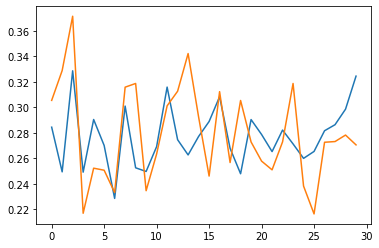

In [222]:
plt.plot(y_test)
plt.plot(predict)
plt.show() # 시간이 갈수록 예측력이 떨어짐, event 발생에 대한 예측력이 떨어짐

In [223]:
# 예측값, 실제값 확인 
print(predict, y_test)

[[0.30550385]
 [0.32893783]
 [0.37163788]
 [0.21678333]
 [0.25221372]
 [0.25061435]
 [0.23306984]
 [0.3158911 ]
 [0.31879595]
 [0.23451927]
 [0.26336753]
 [0.30120784]
 [0.31270736]
 [0.34230533]
 [0.29247278]
 [0.24602115]
 [0.3123702 ]
 [0.25665867]
 [0.3054263 ]
 [0.27282235]
 [0.25778186]
 [0.25091618]
 [0.27289248]
 [0.318799  ]
 [0.23817793]
 [0.21627054]
 [0.27259323]
 [0.27315015]
 [0.2782467 ]
 [0.27052167]] [0.2844384  0.24933564 0.32876205 0.24909379 0.29047587 0.27007212
 0.22845518 0.30102919 0.25251374 0.2496375  0.26917094 0.31594394
 0.27460193 0.26263407 0.27715154 0.28890348 0.30839446 0.26781402
 0.24784421 0.2904297  0.27870691 0.26525148 0.2821721  0.27128368
 0.25993191 0.2653801  0.28163992 0.28640146 0.29860906 0.32456811]


In [225]:
print(np.mean(abs(predict - y_test))) # check result

0.03581977333922015


## LSTM

In [226]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM
#import CallBack
%matplotlib inline

In [227]:
X_train.shape

(270, 19)

In [231]:
X_train_reshape = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [236]:
model = Sequential() #lstm
model.add(LSTM(16, input_shape=(1,19)))
model.add(Dense(32,activation = "relu"))
model.add(Dense(1))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 16)                2304      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [237]:
#학습
model.compile(loss='mean_squared_error', optimizer='adam')

In [238]:
#visible 40 inputs, hidden layer with 4 LSTM blocks and output makes 18 prediction
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)

model.fit(X_train_reshape, y_train, epochs=100, validation_split = 0.2, verbose = 2, callbacks = [early_stop])

Epoch 1/100
7/7 - 1s - loss: 0.1049 - val_loss: 0.0635
Epoch 2/100
7/7 - 0s - loss: 0.0437 - val_loss: 0.0212
Epoch 3/100
7/7 - 0s - loss: 0.0145 - val_loss: 0.0063
Epoch 4/100
7/7 - 0s - loss: 0.0037 - val_loss: 7.4434e-04
Epoch 5/100
7/7 - 0s - loss: 6.0704e-04 - val_loss: 0.0010
Epoch 6/100
7/7 - 0s - loss: 0.0011 - val_loss: 9.2995e-04
Epoch 7/100
7/7 - 0s - loss: 6.6397e-04 - val_loss: 4.6825e-04
Epoch 8/100
7/7 - 0s - loss: 4.6263e-04 - val_loss: 4.3123e-04
Epoch 9/100
7/7 - 0s - loss: 4.7377e-04 - val_loss: 3.9924e-04
Epoch 10/100
7/7 - 0s - loss: 4.7227e-04 - val_loss: 3.8668e-04
Epoch 11/100
7/7 - 0s - loss: 4.6732e-04 - val_loss: 3.8589e-04
Epoch 12/100
7/7 - 0s - loss: 4.6128e-04 - val_loss: 3.9118e-04
Epoch 13/100
7/7 - 0s - loss: 4.6100e-04 - val_loss: 4.0331e-04
Epoch 14/100
7/7 - 0s - loss: 4.5629e-04 - val_loss: 4.0793e-04
Epoch 15/100
7/7 - 0s - loss: 4.5498e-04 - val_loss: 4.0544e-04
Epoch 16/100
7/7 - 0s - loss: 4.5380e-04 - val_loss: 4.0343e-04
Epoch 17/100
7/7 - 0s

In [239]:
# make predictions
model.evaluate(X_test_reshape, y_test, batch_size=30)

1/1 [==============================] - 0s 6ms/step - loss: 4.4728e-04


0.00044727951171807945

## stacked LSTM

In [240]:
batch_size = 64
look_back = 40

In [241]:
X_train.shape

(270, 19)

In [242]:
#data shape
trainX = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
testX = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [243]:
testX.shape

(30, 19, 1)

In [247]:
stack_model = Sequential()
stack_model.add(LSTM(32, return_sequences = True, input_shape = (1, 19))) 
stack_model.add(LSTM(32))
stack_model.add(Dense(32, activation = 'relu'))
stack_model.add(Dropout(0.3))
stack_model.add(Dense(18))

In [248]:
#학습
stack_model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])

In [249]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)

stack_model.fit(X_train_reshape, y_train, epochs=1000, validation_split = 0.2, verbose = 2, callbacks = [early_stop])

Epoch 1/1000
7/7 - 2s - loss: 0.0675 - mse: 0.0675 - val_loss: 0.0551 - val_mse: 0.0551
Epoch 2/1000
7/7 - 0s - loss: 0.0496 - mse: 0.0496 - val_loss: 0.0372 - val_mse: 0.0372
Epoch 3/1000
7/7 - 0s - loss: 0.0340 - mse: 0.0340 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 4/1000
7/7 - 0s - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 5/1000
7/7 - 0s - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 6/1000
7/7 - 0s - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 7/1000
7/7 - 0s - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 8/1000
7/7 - 0s - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 9/1000
7/7 - 0s - loss: 0.0078 - mse: 0.0078 - val_loss: 9.7320e-04 - val_mse: 9.7320e-04
Epoch 10/1000
7/7 - 0s - loss: 0.0074 - mse: 0.0074 - val_loss: 9.7261e-04 - val_mse: 9.7261e-04
Epoch 11/1000
7/7 - 0s - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 12/1000


In [250]:
#prediction
stack_model.evaluate(X_test_reshape, y_test, batch_size=30)

1/1 [==============================] - 0s 3ms/step - loss: 7.7363e-04 - mse: 7.7363e-04


[0.0007736304542049766, 0.0007736304542049766]

In [92]:
## tuning
### Baysian Optimization
### 딥러닝 튜닝은 Genetic algorithm 사용 (oop)

In [111]:
# ensemble
## cv기반의 stacking methods
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [251]:
predict

array([[0.30550385],
       [0.32893783],
       [0.37163788],
       [0.21678333],
       [0.25221372],
       [0.25061435],
       [0.23306984],
       [0.3158911 ],
       [0.31879595],
       [0.23451927],
       [0.26336753],
       [0.30120784],
       [0.31270736],
       [0.34230533],
       [0.29247278],
       [0.24602115],
       [0.3123702 ],
       [0.25665867],
       [0.3054263 ],
       [0.27282235],
       [0.25778186],
       [0.25091618],
       [0.27289248],
       [0.318799  ],
       [0.23817793],
       [0.21627054],
       [0.27259323],
       [0.27315015],
       [0.2782467 ],
       [0.27052167]], dtype=float32)

In [252]:
# dnn model y값 변경
for i in range(len(predict)):
    arr[i] = predict[i][0]

In [253]:
y_pred_list = list()

for i in range(len(y_pred)):
    y_pred_list.append(lgb_y_pred[i])

In [254]:
arr_list = list()

for i in range(len(y_pred)):
    arr_list.append(arr[i])

In [255]:
# 앙상블에 사용할 모델들
## 딥러닝 중 가장 성능이 좋았던 dnn / multireg 중 가장 성능이 좋았던 rf stackng앙상블 
pred=np.array([y_pred_list, arr_list])
print(pred.shape)

(2, 60)


In [258]:
pred=np.transpose(pred)
print(pred.shape, y_test.shape)

(2, 60) (30,)


# 제일 좋은 predict값
- 딥러닝 모델중 가장 좋은 값 : DNN + hyperparameter tuning ( genetic algorithm )
- 머신러닝 모델중 가장 좋은 값 : LGB + hyperparameter tuning ( random search )
- 결과 : 스태킹 회귀 모델의 최종 RMSE 값은: 0.007915544479213265

In [257]:
# 최종모델 

rf_final.fit(pred, y_test)
final=rf_final.predict(pred)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

ValueError: Number of labels=30 does not match number of samples=60

### multiregressor

In [114]:
y_target = df_all_3['label']
X_data = df_all_3.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.2, random_state=123)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.mean(abs(y_pred - y_test)))

0.0198737460601453
0.014633539779247


In [115]:
y_target = df_all_3['label']
X_data = df_all_3.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.2, random_state=123)

In [116]:
y_test.shape

(60,)

In [117]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.mean(abs(y_pred - y_test)))

0.022154628632201162
0.017991632997886555


In [118]:
## default
import pandas as pd
import numpy as np

## model requirements
import tensorflow as tf
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM
from sklearn.model_selection import train_test_split 
#import CallBack
%matplotlib inline
import os

<BarContainer object of 240 artists>

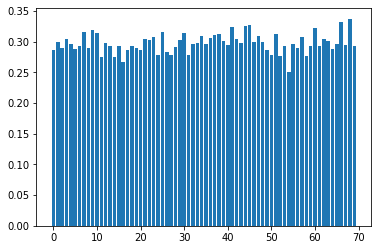

In [119]:
plt.bar(y_train.index, y_train)

<BarContainer object of 60 artists>

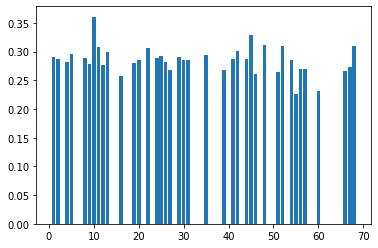

In [120]:
plt.bar(y_test.index, y_test)

In [121]:
# scaler
sc = MinMaxScaler()
X_train=sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test) 

X_train_reshape = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# check shape
print(X_train_reshape.shape)
print(X_test_reshape.shape)

(240, 1, 18)
(60, 1, 18)


In [122]:
y_train

0     0.229880
32    0.268290
57    0.307466
53    0.292491
35    0.259932
        ...   
36    0.290476
13    0.292179
17    0.264070
20    0.269101
28    0.272811
Name: label, Length: 240, dtype: float64

In [187]:
y_target = df_all_3['label']
X_data = df_all_3.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.2, random_state=123)

lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
lgb_y_pred = lgb.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, lgb_y_pred)))
print(np.mean(abs(lgb_y_pred - y_test)))

0.01984400803179539
0.014299569084676177


In [124]:
df_all.describe()

,T_ID,VS_T_ID,PA,AB,RBI,RUN,HIT,H2,H3,HR,...,OBP,SLG,OPS,GPA,IsoP,RC,XR,BABIP,OPS_plus,label
count,300.00000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,4.50000,4.526481,39.395926,34.743148,4.978889,5.268148,9.782963,1.751111,0.157037,1.000185,...,0.343879,0.417085,0.760964,0.259017,0.141859,5.437279,5.193562,0.315832,100.266008,0.277250
std,2.87708,0.839786,1.446727,1.115156,1.017137,1.054293,1.039872,0.370064,0.105926,0.364217,...,0.024528,0.048667,0.069252,0.021800,0.032960,1.058462,0.916682,0.023378,15.984449,0.022159
min,0.00000,2.444444,35.277778,32.111111,2.500000,2.666667,6.833333,0.777778,0.000000,0.277778,...,0.262361,0.291872,0.570096,0.197535,0.069041,2.803282,2.612667,0.245579,54.338950,0.206963
25%,2.00000,3.888889,38.486111,33.944444,4.333333,4.611111,9.166667,1.444444,0.055556,0.722222,...,0.327585,0.381557,0.715684,0.245623,0.117291,4.818845,4.655722,0.299894,90.244623,0.264053
50%,4.50000,4.500000,39.333333,34.666667,4.972222,5.194444,9.722222,1.722222,0.166667,0.944444,...,0.344005,0.416593,0.760778,0.258507,0.139984,5.414171,5.177222,0.315897,99.881795,0.277573
75%,7.00000,5.055556,40.388889,35.555556,5.611111,5.902778,10.444444,2.000000,0.222222,1.222222,...,0.360136,0.450956,0.809521,0.274145,0.163714,6.032268,5.719889,0.331489,110.012920,0.292167
max,9.00000,6.555556,44.055556,38.888889,9.444444,9.666667,14.444444,2.777778,0.555556,2.333333,...,0.418698,0.590812,1.009509,0.336117,0.230927,10.430870,8.967333,0.393909,159.569895,0.360879


In [125]:
df_all.plot

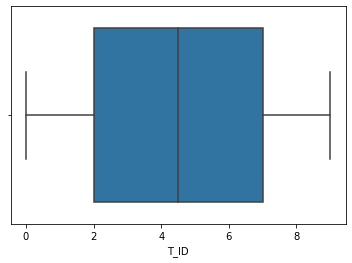

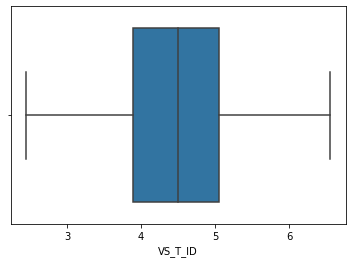

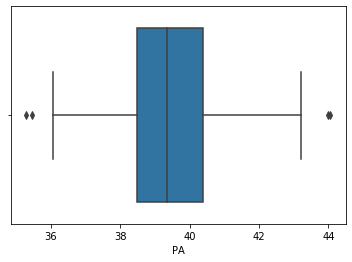

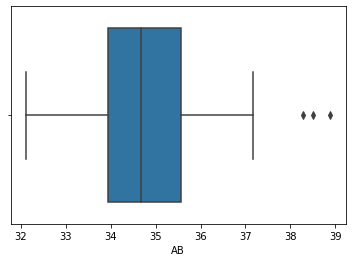

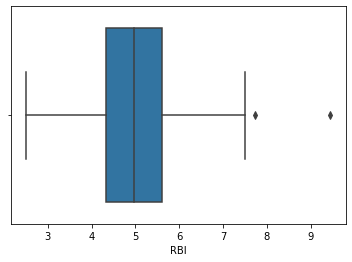

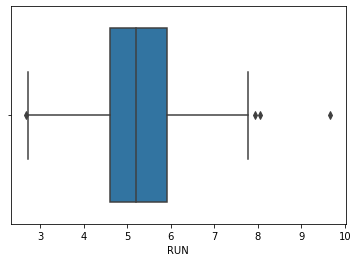

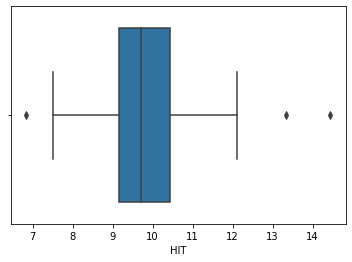

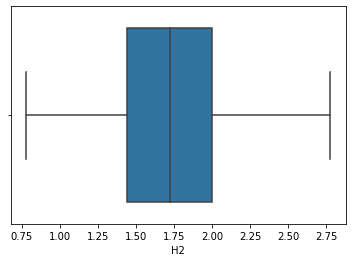

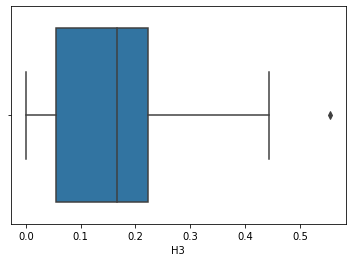

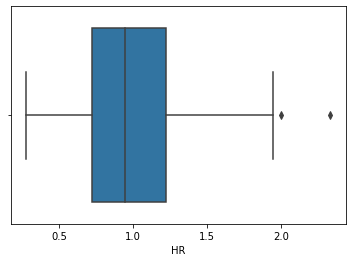

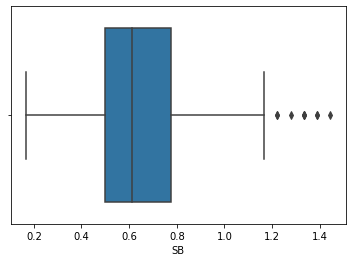

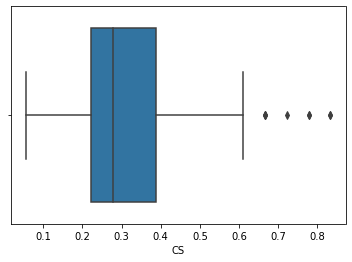

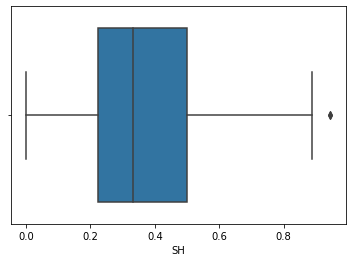

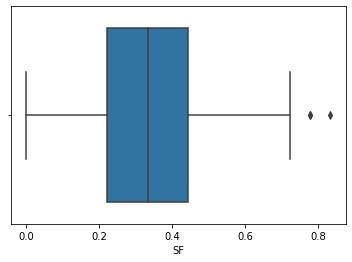

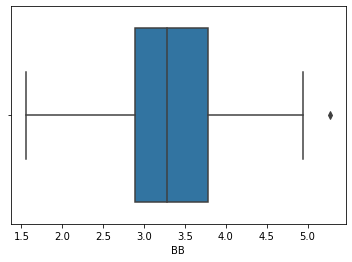

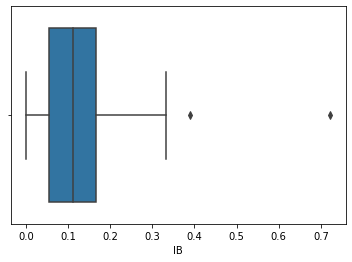

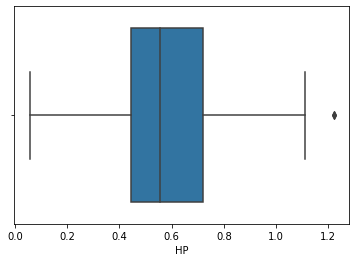

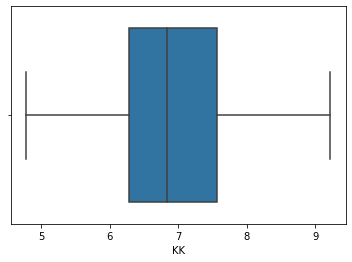

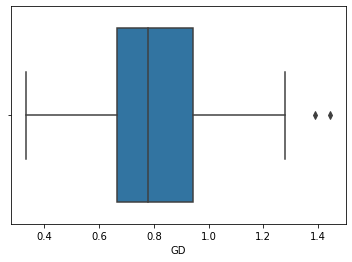

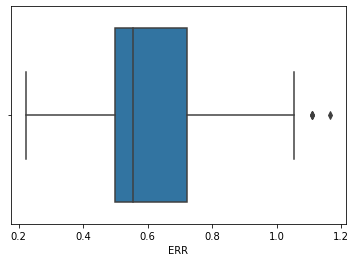

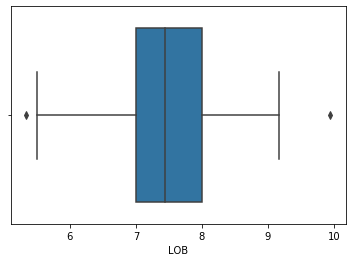

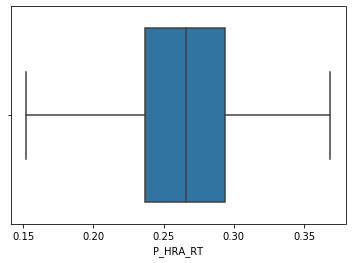

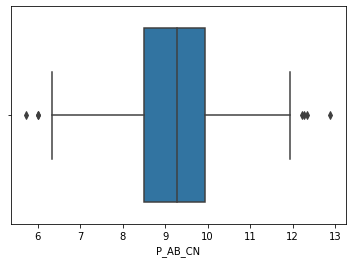

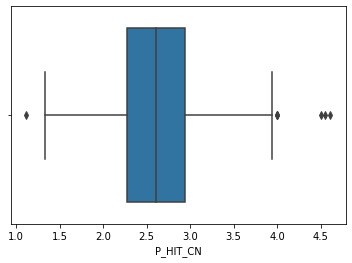

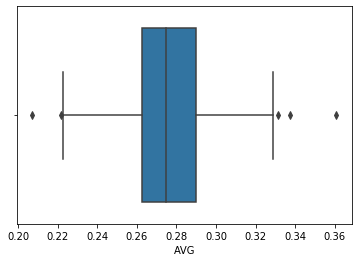

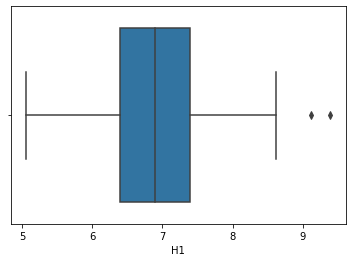

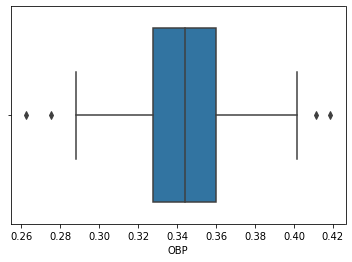

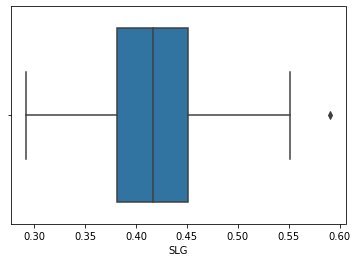

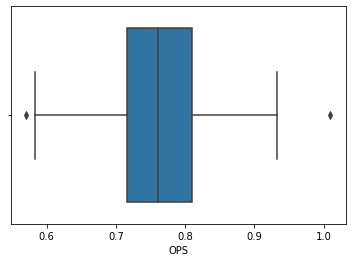

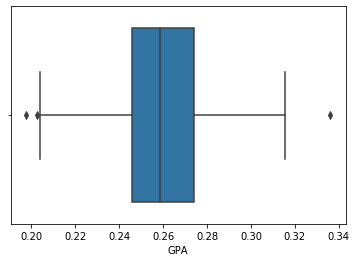

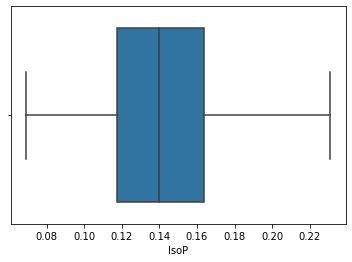

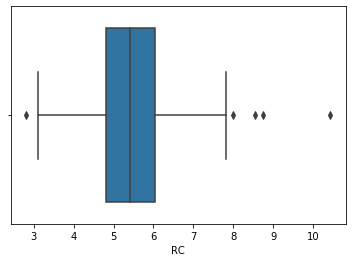

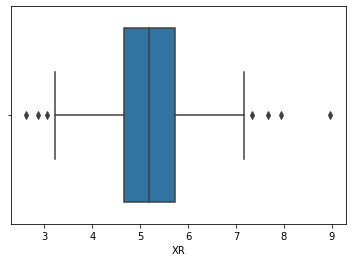

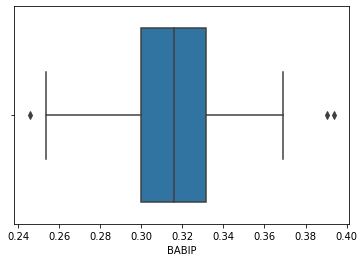

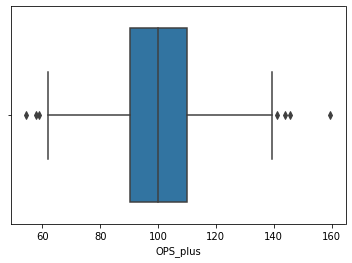

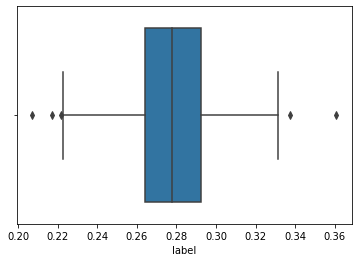

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

for i in df_all.columns:
  sns.boxplot(df_all[i])
  plt.show()

In [127]:
from sklearn.ensemble import IsolationForest

df_all_4 = df_all_3

clf=IsolationForest(random_state=10, contamination=float(0.04))
clf.fit(df_all_4)

pred = clf.predict(df_all_4)
df_all_4['anomaly']=pred
outliers=df_all_4.loc[df_all_4['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df_all_4['anomaly'].value_counts())
df_all_4 = df_all_4[df_all_4['anomaly']==1]
df_all_4.drop(['anomaly'], axis=1, inplace=True)
df_all_4.shape

 1    288
-1     12
Name: anomaly, dtype: int64


(288, 19)

In [128]:
df_all_4

,AB,RBI,RUN,BB,IB,KK,GD,P_HRA_RT,AVG,OBP,SLG,OPS,GPA,IsoP,RC,XR,BABIP,OPS_plus,label
0,35.111111,3.500000,3.722222,3.222222,0.222222,8.166667,1.111111,0.239167,0.263539,0.332277,0.357191,0.689468,0.238822,0.093652,4.285463,4.129667,0.330310,76.668216,0.251589
1,33.611111,4.222222,4.500000,4.055556,0.166667,7.333333,0.833333,0.221771,0.251589,0.338219,0.378336,0.716555,0.246783,0.126747,4.722567,4.648556,0.292843,83.277284,0.298701
2,36.555556,6.444444,6.611111,3.777778,0.166667,6.444444,0.666667,0.327497,0.298701,0.371567,0.458981,0.830548,0.281950,0.160280,6.424161,6.095667,0.333523,111.479614,0.288870
3,35.611111,5.055556,5.055556,2.888889,0.166667,7.722222,0.833333,0.277988,0.288870,0.346885,0.460150,0.807035,0.271136,0.171280,5.776253,5.543222,0.331675,104.832128,0.303723
4,35.722222,7.166667,7.333333,4.555556,0.000000,5.777778,0.833333,0.328565,0.303723,0.383890,0.470915,0.854805,0.290479,0.167192,6.884832,6.519333,0.331479,117.724848,0.296674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,32.666667,4.166667,4.277778,4.277778,0.222222,7.166667,0.611111,0.252293,0.235492,0.326529,0.374645,0.701174,0.240599,0.139153,4.451683,4.421000,0.270006,89.242223,0.250313
16,32.666667,4.666667,4.944444,3.277778,0.055556,6.611111,0.722222,0.244040,0.239933,0.308405,0.371756,0.680160,0.231721,0.131822,4.278111,4.136000,0.269153,83.157836,0.257368
17,33.000000,4.888889,5.055556,3.166667,0.055556,6.833333,0.722222,0.268755,0.257368,0.326628,0.410181,0.736809,0.249528,0.152814,4.838114,4.726444,0.289025,98.042998,0.281640
18,34.000000,5.055556,5.444444,3.833333,0.111111,7.777778,0.555556,0.296792,0.248961,0.329774,0.399211,0.728985,0.248201,0.150250,5.292713,4.995556,0.293416,96.267586,0.271018


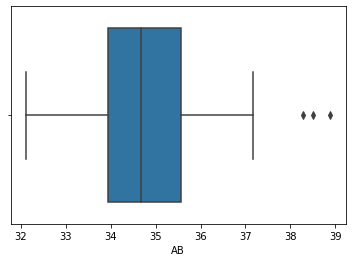

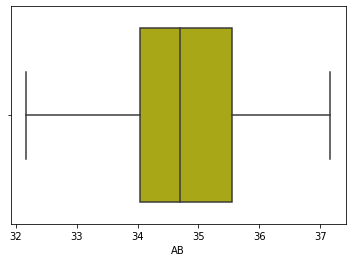

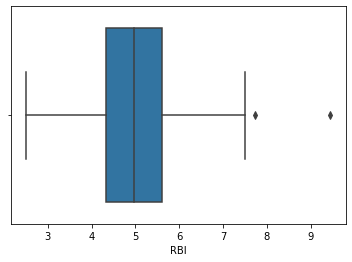

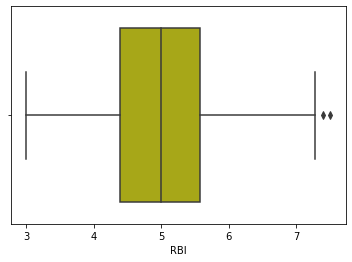

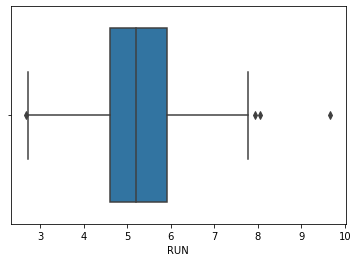

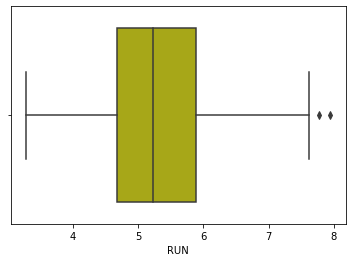

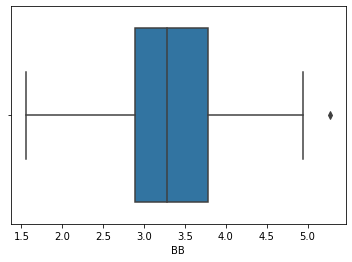

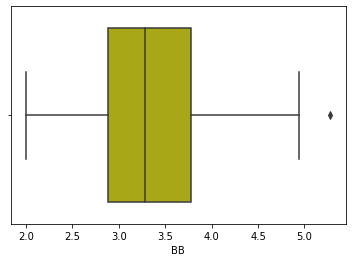

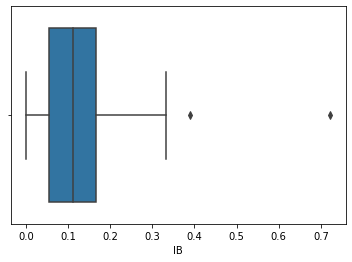

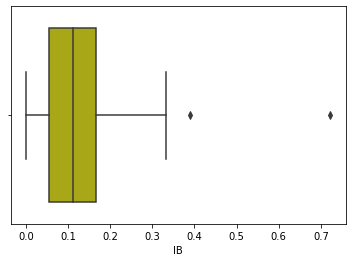

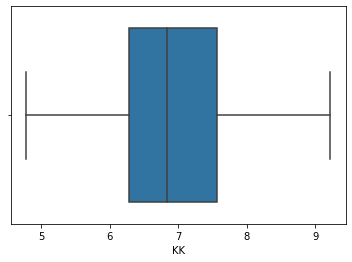

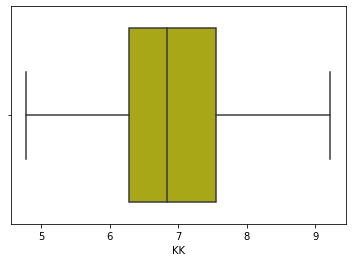

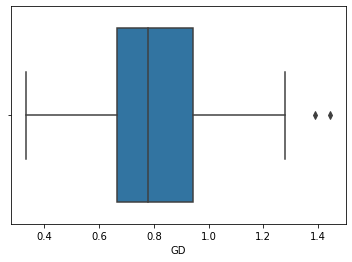

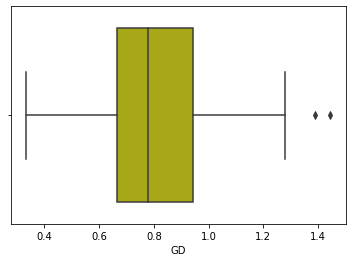

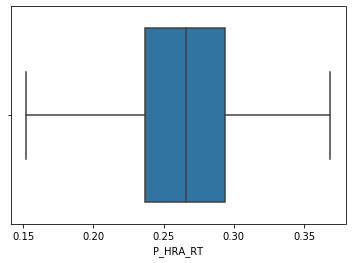

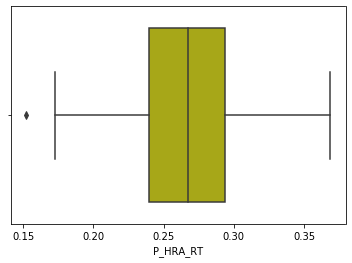

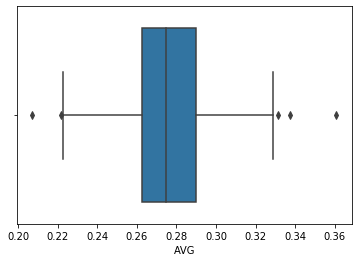

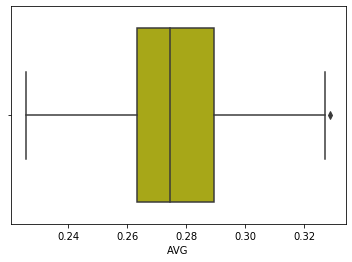

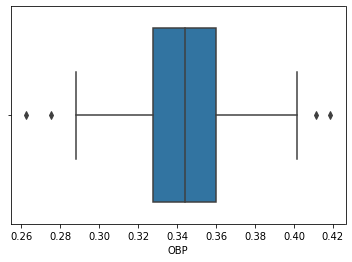

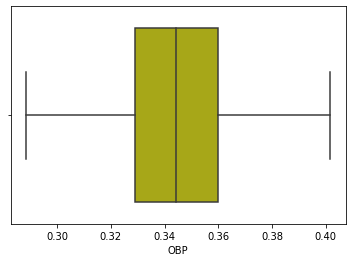

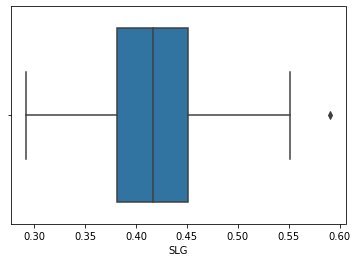

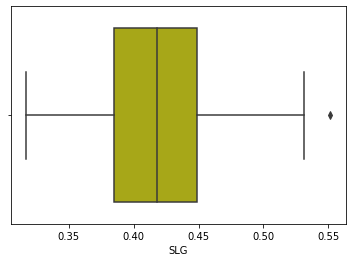

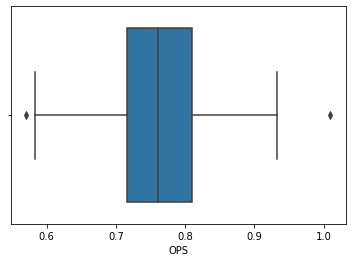

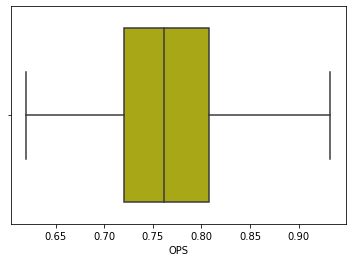

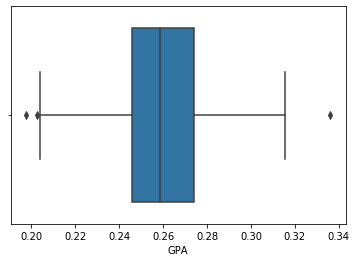

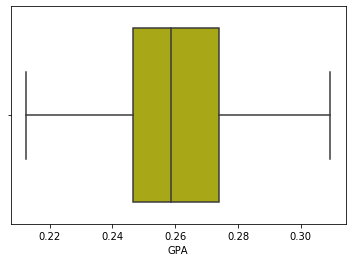

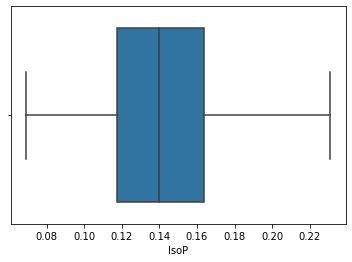

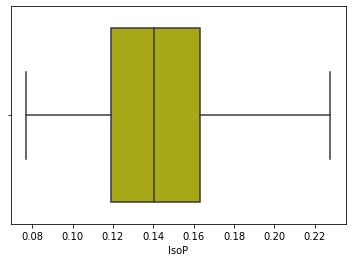

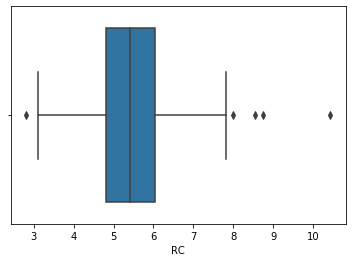

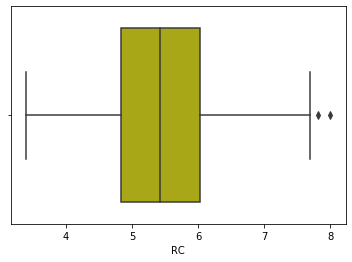

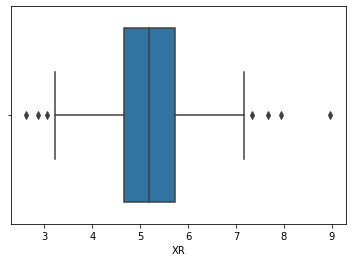

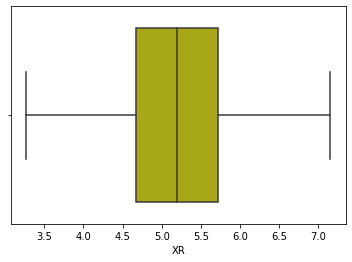

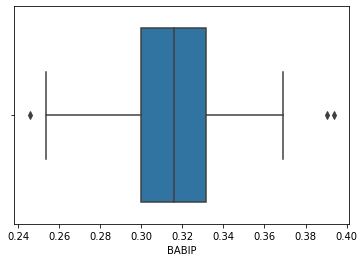

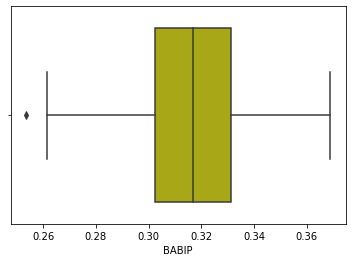

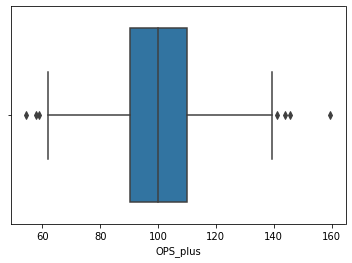

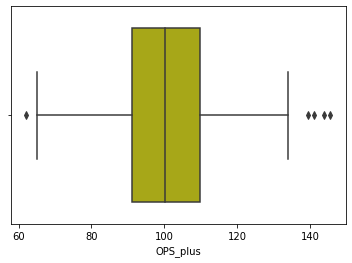

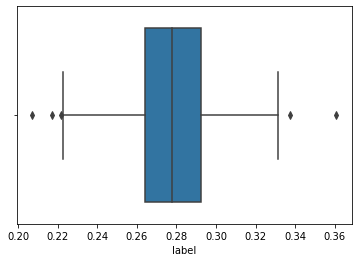

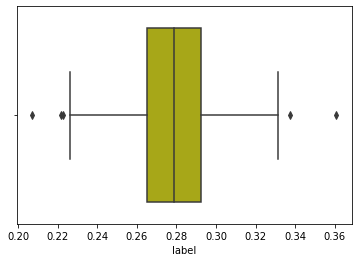

In [129]:
for i,k in zip(df_all_3.columns, df_all_4.columns):
  
  sns.boxplot(df_all_3[i])
  plt.show()
  sns.boxplot(df_all_4[k], color='y')
  plt.show()

In [130]:
y_target = df_all_4['label']
X_data = df_all_4.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.2, random_state=123)

In [131]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.020438272760683173


In [132]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.0235805964204857


In [133]:
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

0.02183248078096967


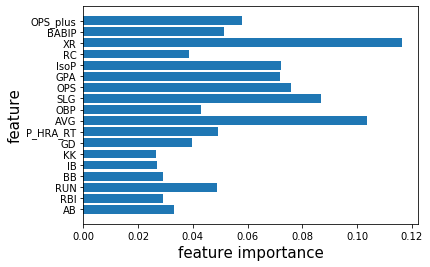

In [134]:
import matplotlib.pyplot as plt
%matplotlib inline

n_feature = X_data.shape[1]

index = np.arange(n_feature)

plt.barh(index, xgb.feature_importances_)

plt.yticks(index, X_data.columns)


plt.xlabel('feature importance', size=15)

plt.ylabel('feature', size=15)

plt.show()



In [135]:
df_all_5 = df_all_3

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(df_all_5)
df_all_5 = scaler.transform(df_all_5)
np.mean(df_all_5), np.std(df_all_5)

(0.44926052891941876, 0.21520969997422384)

In [136]:
df_all_5 = pd.DataFrame(df_all_5, columns=df_all_3.columns)

In [137]:
y_target = df_all_5['label']
X_data = df_all_5.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.2, random_state=123)

In [138]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.mean(abs(y_pred - y_test)))

0.13050662496741444
0.09454000796462715


In [139]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.mean(abs(y_pred - y_test)))

0.13064598539313044
0.09974229027884159


In [140]:
lgb = LGBMRegressor()
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.mean(abs(y_pred - y_test)))

0.1324863414186641
0.09781551287524119


In [141]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [142]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
pred = rf_random.predict(X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.3min finished


In [143]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [144]:
best_model = RandomForestRegressor(n_estimators = 1400, 
                                    min_samples_split = 10,
                                    min_samples_leaf = 2,
                                    max_features = 'sqrt',
                                    max_depth = 80,
                                    bootstrap = True,
                                    random_state = 10)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.mean(abs(y_pred - y_test)))

0.12827047509846795
0.0951823288979369
